# In this notebook we try to collect information about different neighborhoods of Mumbai city and try to cluster them together, helping not only home-hunters find places of their choice but also developers and investors who can understand popular, existing amenities in these areas.

### Importing necessary libraries

In [2]:
# For numerical data and dataframe handling
import numpy as np 
import pandas as pd 

# For web scraping data
from bs4 import BeautifulSoup
import requests

# For obtaining coordinates from Location
from geopy.geocoders import Nominatim 

# For reading url resutls
import requests 

# For clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# For creating Maps & Visualizations
import folium 
import matplotlib.pyplot as plt

# Local file containing API keys
import config

# For preprocessing data collected
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# For understanding JSON files
from pandas.io.json import json_normalize
import json

print('Libraries imported.')

Libraries imported.


### Scraping data about neighborhoods and their Avg Rent from a website containing 102 pages of data

In [48]:
row_data # List for storing Neighborhoods and it corresponding Average Rent
for i in range(1,103):
    
    # URL of the webpage
    url='https://www.makaan.com/price-trends/property-rates-for-rent-in-mumbai?page='
    
    url = url + str(i)
    html = requests.get(url).text
    soup = BeautifulSoup(html, "lxml")
    neighborhood = soup.find("table", attrs={"class": "tbl"})
    neighborhood_data = neighborhood.tbody.find_all("tr")
    
    for i in range(len(neighborhood_data)):
        
        row = []
        row.append(neighborhood_data[i].find("a").text)
        row.append(neighborhood_data[i].find_all("td", attrs={"class": "caps ta-c"})[1].text.strip())
        row_data.append(row)

In [55]:
# Print first 10 elements contaning Neighborhood and corresponding Average Rent
print(row_data[:10])

[['Thane West', '27,333.33'], ['Mira Road East', '30,000'], ['Kharghar', '32,000'], ['Chembur', '39,000'], ['Kandivali East', '33,694.62'], ['Powai', '85,000'], ['Goregaon East', '30,000'], ['Dombivali', '13,000'], ['Ulwe', '10,000'], ['Andheri East', '22,000']]


### Converting the scraped data in a dataframe

In [56]:
df =  pd.DataFrame(row_data, columns=['Neighborhood', 'Avg 2BHK Rent'])
df.head()

,Neighborhood,Avg 2BHK Rent
0,Thane West,"27,333.33"
1,Mira Road East,"30,000"
2,Kharghar,"32,000"
3,Chembur,"39,000"
4,Kandivali East,"33,694.62"


In [58]:
df.shape # Find the number of Neighborhoods (6139)

(6139, 2)

In [70]:
# Check for null values
df.isnull().values.any()

False

In [71]:
df.tail()

,Neighborhood,Avg 2BHK Rent
6134,Zaveri Bazar,-
6135,Zaveri Bazar,-
6136,Zig Zag Road,-
6137,Ziral Ali,-
6138,Zoroastrian Colony,-


### Towards the end of the dataframe we find many Neighborhoods have '-' as Avg Rent, implying missing values which need to be removed. 

In [74]:
(df['Avg 2BHK Rent'] == '-').sum() # Find the number of missing values (5666)

5666

### This is expected as it is very difficult to imagine cities with thousands of neighborhoods. We need to only consider a few hundred major neighborhoods.

In [78]:
# Remove the extra neighborhoods
df = df[df['Avg 2BHK Rent'] != '-']
df = df.reset_index()
df = df[['Neighborhood', 'Avg 2BHK Rent']]
print(df.shape)
df.tail()

(473, 2)


,Neighborhood,Avg 2BHK Rent
468,CENTRAL PARK,"50,000"
469,Chuim Village,"40,000"
470,Eastern Express Highway,"25,000"
471,PL Lokhande Marg,"30,000"
472,Sector-4 Kopar Khairane,"21,000"


### We now have 473 Mumbai Neighborhoods with their Avg Rents in the dataframe. We now use geolocator library to find the coordinates of each neighborhood and add it to the dataframe.

In [93]:
lat = []
lon = []
for i in range(len(df)):
    
    # Create the address string
    address = df['Neighborhood'][i]
    add = ', Mumbai, India'
    address = address + add

    # Find the coordinates using the address string
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(address)
    try:
        latitude = location.latitude
        longitude = location.longitude
        lat.append(latitude)
        lon.append(longitude)
        print('The geograpical coordinate of {}, Mumbai, India are {}, {}.'.format(df['Neighborhood'][i], latitude, longitude))
    except:
        # Replace unavailable coordinates by NaN
        lat.append(None)
        lon.append(None)
        print('The geograpical coordinate of {}, Mumbai, India are unavailable.'.format(df['Neighborhood'][i]))    

The geograpical coordinate of Thane West, Mumbai, India are 19.17502, 72.9718018.
The geograpical coordinate of Mira Road East, Mumbai, India are 19.1878962, 72.8365955.
The geograpical coordinate of Kharghar, Mumbai, India are 19.0257731, 73.05918477985664.
The geograpical coordinate of Chembur, Mumbai, India are 19.0612128, 72.8975909.
The geograpical coordinate of Kandivali East, Mumbai, India are 19.2103809, 72.8640837.
The geograpical coordinate of Powai, Mumbai, India are 19.1187195, 72.9073476.
The geograpical coordinate of Goregaon East, Mumbai, India are 19.1692623, 72.8552548.
The geograpical coordinate of Dombivali, Mumbai, India are unavailable.
The geograpical coordinate of Ulwe, Mumbai, India are 18.9804364, 73.0387309.
The geograpical coordinate of Andheri East, Mumbai, India are 19.1158835, 72.854202.
The geograpical coordinate of Virar, Mumbai, India are 19.4676823, 72.8879975.
The geograpical coordinate of Panvel, Mumbai, India are 19.0500265, 72.9333337.
The geograpi

The geograpical coordinate of Neral, Mumbai, India are 19.0266373, 73.3181185.
The geograpical coordinate of Worli, Mumbai, India are 19.0116962, 72.8180702.
The geograpical coordinate of Bhiwandi, Mumbai, India are unavailable.
The geograpical coordinate of Jogeshwari West, Mumbai, India are 19.136394, 72.8373817.
The geograpical coordinate of Parel, Mumbai, India are 19.0094817, 72.8376614.
The geograpical coordinate of mumbai, Mumbai, India are 18.9387711, 72.8353355.
The geograpical coordinate of Ambernath East, Mumbai, India are unavailable.
The geograpical coordinate of Virar West, Mumbai, India are 19.4676823, 72.8879975.
The geograpical coordinate of Prabhadevi, Mumbai, India are 19.0148811, 72.8279556.
The geograpical coordinate of Seawoods, Mumbai, India are 19.0221923, 73.01873756602905.
The geograpical coordinate of Karanjade, Mumbai, India are unavailable.
The geograpical coordinate of Bandra East, Mumbai, India are 19.0616565, 72.8498111.
The geograpical coordinate of Kha

The geograpical coordinate of Sector-18 Ulwe, Mumbai, India are 19.02291925, 73.04793003737667.
The geograpical coordinate of Sector 21 Kamothe, Mumbai, India are unavailable.
The geograpical coordinate of Thakur Village, Mumbai, India are 19.2097189, 72.8759248.
The geograpical coordinate of Malabar Hill, Mumbai, India are 18.9581616, 72.8033665.
The geograpical coordinate of Diva, Mumbai, India are unavailable.
The geograpical coordinate of Kasar vadavali, Mumbai, India are unavailable.
The geograpical coordinate of Lokhandwala complex, Mumbai, India are 19.1431604, 72.8246332.
The geograpical coordinate of Mumbai Central, Mumbai, India are 18.9695855, 72.8193152.
The geograpical coordinate of matunga east, Mumbai, India are 19.0261579, 72.8520846.
The geograpical coordinate of Thakurli, Mumbai, India are unavailable.
The geograpical coordinate of Thane East, Mumbai, India are 19.1693436, 72.9667636.
The geograpical coordinate of Matunga, Mumbai, India are 19.0274356, 72.8501467.
The

The geograpical coordinate of Chembur Shell Colony, Mumbai, India are 19.0487974, 72.8878464.
The geograpical coordinate of Sector 18 Kharghar, Mumbai, India are 19.073701399999997, 73.08193505.
The geograpical coordinate of Central Avenue, Mumbai, India are 19.0420201, 72.9249348.
The geograpical coordinate of Sector 9 Airoli, Mumbai, India are unavailable.
The geograpical coordinate of West Amardeep Colony, Mumbai, India are 19.1789422, 72.94758325000001.
The geograpical coordinate of Sai Samarth Mitra, Mumbai, India are unavailable.
The geograpical coordinate of Sector 11 Koparkhairane, Mumbai, India are 19.1055916, 73.0008759.
The geograpical coordinate of Western Express Highway Malad East, Mumbai, India are 19.1848459, 72.8585169.
The geograpical coordinate of Kalina, Mumbai, India are 19.079273, 72.8612672.
The geograpical coordinate of Amboli, Mumbai, India are 19.1319915, 72.8499596.
The geograpical coordinate of Sector24 Kamothe, Mumbai, India are unavailable.
The geograpical

The geograpical coordinate of Western Express Highway Santacruz East, Mumbai, India are 19.0903754, 72.8437849.
The geograpical coordinate of 15th Rd, Mumbai, India are 19.070757, 72.8320648.
The geograpical coordinate of Andheri Railway Station East Middle Overpass, Mumbai, India are unavailable.
The geograpical coordinate of colaba post office, Mumbai, India are 18.915091, 72.8259691.
The geograpical coordinate of Ganesh Nagar, Mumbai, India are 19.1515483, 72.9300624.
The geograpical coordinate of Hariyali, Mumbai, India are 19.1136865, 72.929775.
The geograpical coordinate of Jacob Circle, Mumbai, India are 18.9810531, 72.82678629995553.
The geograpical coordinate of Mahakali Road, Mumbai, India are 19.1306093, 72.87381645183467.
The geograpical coordinate of Off Carter Road, Mumbai, India are 19.0607341, 72.8222907.
The geograpical coordinate of Prabhadevi mumbai, Mumbai, India are 19.0148811, 72.8279556.
The geograpical coordinate of Sector 16 A, Mumbai, India are unavailable.
Th

In [95]:
df['Latitude'] = lat
df['Longitude'] = lon
df.head(10)

,Neighborhood,Avg 2BHK Rent,Latitude,Longitude
0,Thane West,"27,333.33",19.175020,72.971802
1,Mira Road East,"30,000",19.187896,72.836596
2,Kharghar,"32,000",19.025773,73.059185
3,Chembur,"39,000",19.061213,72.897591
4,Kandivali East,"33,694.62",19.210381,72.864084
5,Powai,"85,000",19.118720,72.907348
6,Goregaon East,"30,000",19.169262,72.855255
7,Dombivali,"13,000",NaN,NaN
8,Ulwe,"10,000",18.980436,73.038731
9,Andheri East,"22,000",19.115883,72.854202


### We observe that coordinates for some neighborhoods are not available with the library. We drop these neighborhoods.

In [96]:
df.dropna(inplace=True)
df.head(10)

,Neighborhood,Avg 2BHK Rent,Latitude,Longitude
0,Thane West,"27,333.33",19.175020,72.971802
1,Mira Road East,"30,000",19.187896,72.836596
2,Kharghar,"32,000",19.025773,73.059185
3,Chembur,"39,000",19.061213,72.897591
4,Kandivali East,"33,694.62",19.210381,72.864084
5,Powai,"85,000",19.118720,72.907348
6,Goregaon East,"30,000",19.169262,72.855255
8,Ulwe,"10,000",18.980436,73.038731
9,Andheri East,"22,000",19.115883,72.854202
10,Virar,"8,000",19.467682,72.887997


### Now we check our data for duplicate values

In [106]:
print('Total number of neighborhoods: {}'.format(df.shape[0]))
print('Total number of unique neighborhoods: {}'.format(len(df['Neighborhood'].unique())))

Total number of neighborhoods: 326
Total number of unique neighborhoods: 277


### We see that we have 326 neighborhoods but only 277 of them are unique. We remove the 49 duplicate neighborhoods.

In [109]:
df.drop_duplicates(subset ="Neighborhood", keep = 'first', inplace = True) 
print(df.shape)

(277, 4)


### Using this dataframe we plot all these Neighborhoods on a map of Mumbai using their coordinates.

In [388]:
# Find coordinates of Mumbai for creating its map
address = 'Mumbai, India'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mumbai are 18.9387711, 72.8353355.


In [121]:
map_mumbai = folium.Map(location=[latitude, longitude], zoom_start=10)

# Add markers to map
for lat, lng, nei in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    
    # Add each neighborhood as a marker on the map
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#F9D423',
        fill_opacity=0.85,
        parse_html=False).add_to(map_mumbai)  
    
# Display the map    
map_mumbai

### With that out of the way, we now use the FourSquare API to add the most common venues of each neighborhood to our dataframe

In [122]:
venues=[]

for name, lat, long in zip(df['Neighborhood'], df['Latitude'], df['Longitude']):
    
    limit=100   # Limit search to 100 values
    radius=1000 # Limit search to a 1km radius
    
    # Create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        config.CLIENT_ID, 
        config.CLIENT_SECRET, 
        config.VERSION, 
        lat, 
        long, 
        radius, 
        limit)    
    # Make the GET request to the API
    results = requests.get(url).json()["response"]['groups'][0]['items']

    # Return only relevant information for each nearby venue
    venues.append([(
        name, 
        lat, 
        long, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])


In [179]:
# Verify the number of neighborhoods searched successfully
len(venues)

277

In [182]:
# Create a new dataframe with nearby venues of each neighborhood,its category and its coordinates
nearby_venues = pd.DataFrame([item for venue in venues for item in venue])
nearby_venues.columns = ['Neighborhood', 
              'Neighborhood Latitude', 
              'Neighborhood Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']
nearby_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Thane West,19.17502,72.971802,CreamChills,19.182282,72.976087,Dessert Shop
1,Thane West,19.17502,72.971802,octrai naka,19.174171,72.969554,Border Crossing
2,Thane West,19.17502,72.971802,Mantri Dhaba,19.176448,72.967507,Indian Restaurant
3,Thane West,19.17502,72.971802,Bandra,19.170767,72.968389,Train Station
4,Thane West,19.17502,72.971802,A to Z General Stores,19.176244,72.965667,Smoke Shop


In [185]:
# Check rows in new dataframe
nearby_venues.shape

(9920, 7)

In [186]:
# Check the number of venues found for each neighborhood
nearby_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
114 Goregaon Mulund Link Road,5,5,5,5,5,5
14TH ROAD,100,100,100,100,100,100
15th Rd,100,100,100,100,100,100
16th Cross Road,100,100,100,100,100,100
16th Rd,68,68,68,68,68,68
Agripada,38,38,38,38,38,38
Airoli,1,1,1,1,1,1
Almeida Park,100,100,100,100,100,100
Ambivali,100,100,100,100,100,100


In [187]:
# Find total number of unique categories found
print('There are {} uniques categories.'.format(len(nearby_venues['Venue Category'].unique())))

There are 257 uniques categories.


### We now create another dataframe, one hot encoding all neighborhood venues

In [189]:
# One hot encoding
mumbai_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe as neighbor
mumbai_onehot['Neighbor'] = nearby_venues['Neighborhood'] 

# Move neighbor column to the first column
fixed_columns = [mumbai_onehot.columns[-1]] + list(mumbai_onehot.columns[:-1])
mumbai_onehot = mumbai_onehot[fixed_columns]

mumbai_onehot.head()

,Neighbor,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,...,Track,Train,Train Station,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,Thane West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Thane West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Thane West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Thane West,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Thane West,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Another dataframe is created with each venue value representing its commonness in the neighborhood

In [190]:
mumbai_grouped = mumbai_onehot.groupby('Neighbor').mean().reset_index()
mumbai_grouped

,Neighbor,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,...,Track,Train,Train Station,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,114 Goregaon Mulund Link Road,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,14TH ROAD,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,15th Rd,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,16th Cross Road,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,16th Rd,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.014706,0.000000,0.0
5,Agripada,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6,Airoli,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,Almeida Park,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.0
8,Ambivali,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.030000,0.000000,0.000000,0.000000,0.010000,0.000000,0.0
9,Amboli,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


### We the use above data to create a dataframe with the top ten venues in each neighborhood.

In [191]:
# Function to return most common venues for a neighborhood
def common_venues(row, num_of_top):
    
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_of_top]

In [193]:
# Number of top venues required
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighborhood']
for indx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(indx+1, indicators[indx]))
    except:
        columns.append('{}th Most Common Venue'.format(indx+1))

# Create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mumbai_grouped['Neighbor']

for indx in np.arange(mumbai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[indx, 1:] = common_venues(mumbai_grouped.iloc[indx, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,114 Goregaon Mulund Link Road,Bus Station,Restaurant,Fast Food Restaurant,Pizza Place,Train Station,Electronics Store,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant
1,14TH ROAD,Indian Restaurant,Café,Bar,Italian Restaurant,Bakery,Lounge,Seafood Restaurant,Pub,Asian Restaurant,Dessert Shop
2,15th Rd,Indian Restaurant,Bar,Bakery,Lounge,Seafood Restaurant,Fast Food Restaurant,Italian Restaurant,Café,Dessert Shop,Asian Restaurant
3,16th Cross Road,Indian Restaurant,Bakery,Bar,Dessert Shop,Lounge,Italian Restaurant,Café,Seafood Restaurant,Asian Restaurant,Cupcake Shop
4,16th Rd,Indian Restaurant,Coffee Shop,Italian Restaurant,Lounge,Bakery,Asian Restaurant,Clothing Store,Café,Gym / Fitness Center,Chinese Restaurant


In [261]:
# Merge the created dataframe with the Rent column
neighborhoods_venues_sorted = pd.merge(neighborhoods_venues_sorted, df[['Neighborhood','Avg 2BHK Rent']], on='Neighborhood')
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Avg 2BHK Rent
0,114 Goregaon Mulund Link Road,Bus Station,Restaurant,Fast Food Restaurant,Pizza Place,Train Station,Electronics Store,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,"44,000"
1,14TH ROAD,Indian Restaurant,Café,Bar,Italian Restaurant,Bakery,Lounge,Seafood Restaurant,Pub,Asian Restaurant,Dessert Shop,"77,750"
2,15th Rd,Indian Restaurant,Bar,Bakery,Lounge,Seafood Restaurant,Fast Food Restaurant,Italian Restaurant,Café,Dessert Shop,Asian Restaurant,"80,000"
3,16th Cross Road,Indian Restaurant,Bakery,Bar,Dessert Shop,Lounge,Italian Restaurant,Café,Seafood Restaurant,Asian Restaurant,Cupcake Shop,"95,000"
4,16th Rd,Indian Restaurant,Coffee Shop,Italian Restaurant,Lounge,Bakery,Asian Restaurant,Clothing Store,Café,Gym / Fitness Center,Chinese Restaurant,"68,000"


### After creating the above dataframe we now try to discover the amenities in each neighborhood. We use the HERE API's free-text query feature for this category search.

In [205]:
neighborhood_amenities = df[['Neighborhood','Latitude','Longitude']]
neighborhood_amenities.head()

,Neighborhood,Latitude,Longitude
0,Thane West,19.175020,72.971802
1,Mira Road East,19.187896,72.836596
2,Kharghar,19.025773,73.059185
3,Chembur,19.061213,72.897591
4,Kandivali East,19.210381,72.864084


In [222]:
# Function to find the number of different facilities by category in each neighborhood
def find_amenities(df, category):
    
    category_amnt = []
    
    for name, lat, long in zip(df['Neighborhood'], df['Latitude'], df['Longitude']):
        
        print(name)
        radius=1000 # Limit search to 1km
        limit=100   # Limit to 100 results
       
        # Create API request URL
        url = 'https://discover.search.hereapi.com/v1/discover?in=circle:{},{};r={}&limit={}&q={}&apiKey={}'.format(
            lat, 
            long, 
            radius, 
            limit, 
            category, 
            config1.KEY)    
        
        # Make the GET request
        results = len(requests.get(url).json()["items"])
        category_amnt.append(results)
    return category_amnt 

In [228]:
# Function call to find the number of hospitals in each neighborhood
hospitals = find_amenities(df,'hospital')
hospitals

Thane West
Mira Road East
Kharghar
Chembur
Kandivali East
Powai
Goregaon East
Ulwe
Andheri East
Virar
Panvel
Andheri West
Mulund West
Malad West
Kalyan West
Borivali West
Bandra West
Dahisar
Bhandup West
Kamothe
Borivali East
Kandivali West
Malad East
Airoli
Goregaon West
Naigaon East
Santacruz East
Lower Parel
Taloja
Kanjurmarg
Wadala
Ghansoli
Neral
Worli
Jogeshwari West
Parel
mumbai
Virar West
Prabhadevi
Seawoods
Bandra East
Khar West
Santacruz West
Mulund East
Vikhroli
Juhu
Sion
Nerul
Sanpada
Ghatkopar West
Dronagiri
Kurla
Thane
Karjat
Boisar
Vashi
Dahisar East
Kalamboli
Jogeshwari East
Chembur East
Kalyan East
Dadar West
Andheri
Virar East
Mira Road
Bhayandar East
Ghatkopar East
Dahisar West
Khar
Belapur
Colaba
Deonar
Bandra Kurla Complex
Kalyan
Wadala East
vile parle west
Mahalaxmi
Dadar East
Shil Phata
Khopoli
Kanjurmarg East
Byculla
Kurla East
Mahim
Ghatkopar
Mulund
Tilak Nagar
Cuffe Parade
Taloje
Rasayani
Sector 17 Ulwe
Kurla West
Roadpali
MATUNGA WEST
Bhandup East
Govandi
Gore

[4,
 30,
 9,
 36,
 30,
 1,
 9,
 0,
 20,
 0,
 8,
 36,
 60,
 53,
 2,
 30,
 44,
 62,
 56,
 10,
 29,
 23,
 33,
 0,
 30,
 43,
 7,
 11,
 2,
 6,
 0,
 11,
 4,
 6,
 30,
 81,
 30,
 0,
 17,
 19,
 9,
 20,
 20,
 24,
 13,
 11,
 21,
 40,
 23,
 91,
 0,
 10,
 9,
 3,
 31,
 58,
 54,
 9,
 23,
 17,
 2,
 55,
 32,
 0,
 30,
 1,
 98,
 32,
 20,
 9,
 2,
 15,
 6,
 2,
 0,
 23,
 7,
 11,
 8,
 17,
 17,
 24,
 12,
 14,
 98,
 45,
 24,
 1,
 0,
 12,
 0,
 19,
 2,
 14,
 7,
 23,
 29,
 33,
 23,
 27,
 10,
 9,
 0,
 8,
 12,
 56,
 1,
 8,
 6,
 6,
 9,
 18,
 22,
 9,
 10,
 9,
 8,
 9,
 30,
 26,
 0,
 11,
 23,
 7,
 40,
 34,
 17,
 0,
 25,
 11,
 24,
 9,
 12,
 15,
 22,
 9,
 14,
 25,
 0,
 2,
 0,
 0,
 0,
 4,
 13,
 43,
 22,
 23,
 32,
 68,
 4,
 21,
 26,
 21,
 12,
 16,
 26,
 12,
 24,
 15,
 27,
 42,
 29,
 20,
 2,
 29,
 30,
 30,
 22,
 1,
 0,
 46,
 24,
 27,
 9,
 41,
 42,
 6,
 0,
 47,
 36,
 0,
 21,
 54,
 69,
 25,
 1,
 4,
 11,
 1,
 31,
 13,
 17,
 26,
 11,
 0,
 30,
 1,
 18,
 6,
 42,
 23,
 5,
 26,
 24,
 16,
 2,
 9,
 11,
 10,
 6,
 35,
 20,
 8,
 16,
 4,

In [232]:
# Function call to find the number of schools in each neighborhood
schools = find_amenities(df,'school')
schools

Thane West
Mira Road East
Kharghar
Chembur
Kandivali East
Powai
Goregaon East
Ulwe
Andheri East
Virar
Panvel
Andheri West
Mulund West
Malad West
Kalyan West
Borivali West
Bandra West
Dahisar
Bhandup West
Kamothe
Borivali East
Kandivali West
Malad East
Airoli
Goregaon West
Naigaon East
Santacruz East
Lower Parel
Taloja
Kanjurmarg
Wadala
Ghansoli
Neral
Worli
Jogeshwari West
Parel
mumbai
Virar West
Prabhadevi
Seawoods
Bandra East
Khar West
Santacruz West
Mulund East
Vikhroli
Juhu
Sion
Nerul
Sanpada
Ghatkopar West
Dronagiri
Kurla
Thane
Karjat
Boisar
Vashi
Dahisar East
Kalamboli
Jogeshwari East
Chembur East
Kalyan East
Dadar West
Andheri
Virar East
Mira Road
Bhayandar East
Ghatkopar East
Dahisar West
Khar
Belapur
Colaba
Deonar
Bandra Kurla Complex
Kalyan
Wadala East
vile parle west
Mahalaxmi
Dadar East
Shil Phata
Khopoli
Kanjurmarg East
Byculla
Kurla East
Mahim
Ghatkopar
Mulund
Tilak Nagar
Cuffe Parade
Taloje
Rasayani
Sector 17 Ulwe
Kurla West
Roadpali
MATUNGA WEST
Bhandup East
Govandi
Gore

[50,
 45,
 8,
 57,
 18,
 22,
 49,
 1,
 53,
 2,
 41,
 35,
 91,
 28,
 7,
 70,
 50,
 64,
 89,
 10,
 44,
 74,
 74,
 0,
 41,
 58,
 22,
 31,
 0,
 37,
 18,
 31,
 27,
 41,
 30,
 81,
 43,
 2,
 58,
 15,
 26,
 16,
 70,
 71,
 34,
 45,
 49,
 71,
 32,
 99,
 0,
 64,
 36,
 43,
 35,
 30,
 61,
 7,
 56,
 53,
 7,
 75,
 84,
 2,
 45,
 11,
 100,
 48,
 16,
 2,
 23,
 38,
 8,
 7,
 18,
 66,
 33,
 62,
 17,
 13,
 49,
 84,
 63,
 45,
 100,
 93,
 39,
 19,
 0,
 12,
 1,
 51,
 8,
 56,
 26,
 38,
 78,
 29,
 20,
 4,
 39,
 96,
 1,
 16,
 21,
 99,
 11,
 16,
 85,
 8,
 39,
 46,
 18,
 100,
 79,
 36,
 75,
 39,
 34,
 74,
 3,
 31,
 33,
 55,
 23,
 50,
 43,
 18,
 59,
 31,
 41,
 21,
 34,
 43,
 37,
 3,
 45,
 46,
 1,
 7,
 1,
 1,
 1,
 23,
 20,
 38,
 8,
 66,
 69,
 100,
 22,
 56,
 32,
 67,
 47,
 51,
 41,
 21,
 61,
 47,
 16,
 90,
 100,
 32,
 8,
 29,
 100,
 7,
 44,
 10,
 20,
 82,
 41,
 78,
 5,
 70,
 35,
 41,
 1,
 100,
 53,
 1,
 53,
 57,
 21,
 46,
 22,
 21,
 25,
 10,
 42,
 53,
 42,
 23,
 31,
 1,
 34,
 10,
 63,
 17,
 100,
 31,
 25,
 41,
 39,
 

In [248]:
# Function call to find the number of emergency services in each neighborhood
emergency_services = find_amenities(df,'emergency')
emergency_services

Thane West
Mira Road East
Kharghar
Chembur
Kandivali East
Powai
Goregaon East
Ulwe
Andheri East
Virar
Panvel
Andheri West
Mulund West
Malad West
Kalyan West
Borivali West
Bandra West
Dahisar
Bhandup West
Kamothe
Borivali East
Kandivali West
Malad East
Airoli
Goregaon West
Naigaon East
Santacruz East
Lower Parel
Taloja
Kanjurmarg
Wadala
Ghansoli
Neral
Worli
Jogeshwari West
Parel
mumbai
Virar West
Prabhadevi
Seawoods
Bandra East
Khar West
Santacruz West
Mulund East
Vikhroli
Juhu
Sion
Nerul
Sanpada
Ghatkopar West
Dronagiri
Kurla
Thane
Karjat
Boisar
Vashi
Dahisar East
Kalamboli
Jogeshwari East
Chembur East
Kalyan East
Dadar West
Andheri
Virar East
Mira Road
Bhayandar East
Ghatkopar East
Dahisar West
Khar
Belapur
Colaba
Deonar
Bandra Kurla Complex
Kalyan
Wadala East
vile parle west
Mahalaxmi
Dadar East
Shil Phata
Khopoli
Kanjurmarg East
Byculla
Kurla East
Mahim
Ghatkopar
Mulund
Tilak Nagar
Cuffe Parade
Taloje
Rasayani
Sector 17 Ulwe
Kurla West
Roadpali
MATUNGA WEST
Bhandup East
Govandi
Gore

[7,
 4,
 0,
 6,
 3,
 3,
 6,
 0,
 9,
 1,
 5,
 8,
 19,
 6,
 2,
 8,
 12,
 12,
 7,
 0,
 10,
 7,
 5,
 0,
 4,
 18,
 6,
 11,
 3,
 14,
 4,
 1,
 2,
 12,
 4,
 16,
 30,
 1,
 9,
 3,
 13,
 13,
 6,
 16,
 9,
 5,
 7,
 3,
 3,
 7,
 0,
 9,
 5,
 4,
 10,
 7,
 11,
 7,
 8,
 10,
 2,
 14,
 11,
 1,
 4,
 2,
 9,
 8,
 13,
 9,
 8,
 5,
 5,
 2,
 4,
 7,
 12,
 9,
 2,
 2,
 8,
 29,
 11,
 7,
 10,
 16,
 6,
 6,
 0,
 2,
 0,
 9,
 0,
 13,
 3,
 9,
 8,
 18,
 4,
 6,
 14,
 14,
 0,
 0,
 3,
 18,
 2,
 0,
 22,
 7,
 2,
 10,
 6,
 15,
 9,
 5,
 9,
 2,
 3,
 6,
 0,
 1,
 4,
 7,
 4,
 7,
 19,
 4,
 20,
 1,
 5,
 1,
 2,
 16,
 5,
 8,
 7,
 3,
 0,
 2,
 0,
 0,
 0,
 6,
 3,
 13,
 9,
 9,
 6,
 20,
 11,
 10,
 3,
 7,
 8,
 10,
 12,
 7,
 6,
 9,
 9,
 14,
 9,
 8,
 4,
 18,
 21,
 6,
 12,
 1,
 3,
 7,
 5,
 6,
 2,
 10,
 12,
 12,
 0,
 19,
 9,
 0,
 10,
 11,
 4,
 3,
 3,
 4,
 5,
 0,
 13,
 3,
 6,
 6,
 11,
 0,
 3,
 1,
 1,
 4,
 29,
 4,
 3,
 12,
 6,
 3,
 2,
 4,
 5,
 4,
 7,
 13,
 6,
 2,
 13,
 1,
 5,
 6,
 18,
 12,
 30,
 6,
 6,
 0,
 4,
 1,
 2,
 11,
 2,
 9,
 8,
 5,
 6,
 8,
 5,

In [249]:
# Function call to find the number of leisure facilities in each neighborhood
leisure = find_amenities(df,'leisure')
leisure

Thane West
Mira Road East
Kharghar
Chembur
Kandivali East
Powai
Goregaon East
Ulwe
Andheri East
Virar
Panvel
Andheri West
Mulund West
Malad West
Kalyan West
Borivali West
Bandra West
Dahisar
Bhandup West
Kamothe
Borivali East
Kandivali West
Malad East
Airoli
Goregaon West
Naigaon East
Santacruz East
Lower Parel
Taloja
Kanjurmarg
Wadala
Ghansoli
Neral
Worli
Jogeshwari West
Parel
mumbai
Virar West
Prabhadevi
Seawoods
Bandra East
Khar West
Santacruz West
Mulund East
Vikhroli
Juhu
Sion
Nerul
Sanpada
Ghatkopar West
Dronagiri
Kurla
Thane
Karjat
Boisar
Vashi
Dahisar East
Kalamboli
Jogeshwari East
Chembur East
Kalyan East
Dadar West
Andheri
Virar East
Mira Road
Bhayandar East
Ghatkopar East
Dahisar West
Khar
Belapur
Colaba
Deonar
Bandra Kurla Complex
Kalyan
Wadala East
vile parle west
Mahalaxmi
Dadar East
Shil Phata
Khopoli
Kanjurmarg East
Byculla
Kurla East
Mahim
Ghatkopar
Mulund
Tilak Nagar
Cuffe Parade
Taloje
Rasayani
Sector 17 Ulwe
Kurla West
Roadpali
MATUNGA WEST
Bhandup East
Govandi
Gore

[27,
 23,
 7,
 35,
 19,
 33,
 25,
 0,
 18,
 0,
 1,
 21,
 27,
 23,
 20,
 43,
 50,
 21,
 15,
 0,
 26,
 29,
 16,
 0,
 30,
 21,
 8,
 37,
 0,
 11,
 15,
 5,
 1,
 19,
 26,
 26,
 27,
 0,
 29,
 23,
 12,
 25,
 25,
 30,
 22,
 36,
 26,
 52,
 12,
 18,
 0,
 15,
 22,
 6,
 10,
 35,
 20,
 2,
 22,
 15,
 20,
 51,
 22,
 0,
 23,
 6,
 43,
 21,
 25,
 26,
 28,
 22,
 6,
 20,
 15,
 33,
 10,
 25,
 4,
 7,
 14,
 30,
 20,
 17,
 38,
 28,
 29,
 23,
 0,
 4,
 0,
 9,
 0,
 28,
 11,
 33,
 31,
 22,
 34,
 25,
 14,
 21,
 0,
 16,
 11,
 45,
 6,
 16,
 20,
 21,
 24,
 31,
 28,
 25,
 27,
 22,
 24,
 24,
 36,
 16,
 0,
 5,
 9,
 20,
 50,
 44,
 38,
 15,
 30,
 5,
 12,
 16,
 46,
 27,
 17,
 35,
 17,
 16,
 0,
 20,
 0,
 0,
 0,
 25,
 29,
 36,
 28,
 30,
 40,
 36,
 8,
 33,
 17,
 28,
 19,
 19,
 14,
 27,
 13,
 19,
 35,
 43,
 21,
 14,
 2,
 24,
 33,
 19,
 11,
 1,
 5,
 22,
 12,
 15,
 8,
 14,
 30,
 19,
 0,
 24,
 27,
 0,
 40,
 45,
 21,
 16,
 33,
 29,
 13,
 12,
 22,
 42,
 19,
 36,
 37,
 0,
 36,
 1,
 6,
 29,
 22,
 11,
 3,
 14,
 29,
 17,
 4,
 6,
 13,
 1

In [250]:
# Function call to find the number of shopping facilties in each neighborhood
shopping = find_amenities(df, 'shopping')
shopping

Thane West
Mira Road East
Kharghar
Chembur
Kandivali East
Powai
Goregaon East
Ulwe
Andheri East
Virar
Panvel
Andheri West
Mulund West
Malad West
Kalyan West
Borivali West
Bandra West
Dahisar
Bhandup West
Kamothe
Borivali East
Kandivali West
Malad East
Airoli
Goregaon West
Naigaon East
Santacruz East
Lower Parel
Taloja
Kanjurmarg
Wadala
Ghansoli
Neral
Worli
Jogeshwari West
Parel
mumbai
Virar West
Prabhadevi
Seawoods
Bandra East
Khar West
Santacruz West
Mulund East
Vikhroli
Juhu
Sion
Nerul
Sanpada
Ghatkopar West
Dronagiri
Kurla
Thane
Karjat
Boisar
Vashi
Dahisar East
Kalamboli
Jogeshwari East
Chembur East
Kalyan East
Dadar West
Andheri
Virar East
Mira Road
Bhayandar East
Ghatkopar East
Dahisar West
Khar
Belapur
Colaba
Deonar
Bandra Kurla Complex
Kalyan
Wadala East
vile parle west
Mahalaxmi
Dadar East
Shil Phata
Khopoli
Kanjurmarg East
Byculla
Kurla East
Mahim
Ghatkopar
Mulund
Tilak Nagar
Cuffe Parade
Taloje
Rasayani
Sector 17 Ulwe
Kurla West
Roadpali
MATUNGA WEST
Bhandup East
Govandi
Gore

[100,
 100,
 83,
 100,
 100,
 100,
 100,
 1,
 100,
 2,
 94,
 100,
 100,
 100,
 53,
 100,
 100,
 100,
 100,
 19,
 100,
 100,
 100,
 4,
 100,
 100,
 85,
 100,
 4,
 100,
 82,
 100,
 100,
 100,
 100,
 100,
 100,
 2,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 0,
 100,
 100,
 98,
 100,
 100,
 100,
 34,
 100,
 100,
 53,
 100,
 100,
 2,
 100,
 11,
 100,
 100,
 100,
 75,
 100,
 100,
 24,
 53,
 82,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 3,
 98,
 1,
 100,
 12,
 100,
 88,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 1,
 80,
 100,
 100,
 11,
 80,
 100,
 52,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 9,
 100,
 100,
 100,
 100,
 100,
 100,
 82,
 100,
 100,
 100,
 70,
 100,
 100,
 100,
 72,
 100,
 100,
 1,
 49,
 1,
 1,
 8,
 97,
 100,
 100,
 100,
 100,
 100,
 100,
 58,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 95,
 49,
 100,
 100,
 100,
 100,
 9,
 32,
 100,
 100,
 100,
 80,
 100,
 100,
 

In [251]:
# Function call to find the number of spiritual centers in each neighborhood
spiritual = find_amenities(df, 'religious place')
spiritual

Thane West
Mira Road East
Kharghar
Chembur
Kandivali East
Powai
Goregaon East
Ulwe
Andheri East
Virar
Panvel
Andheri West
Mulund West
Malad West
Kalyan West
Borivali West
Bandra West
Dahisar
Bhandup West
Kamothe
Borivali East
Kandivali West
Malad East
Airoli
Goregaon West
Naigaon East
Santacruz East
Lower Parel
Taloja
Kanjurmarg
Wadala
Ghansoli
Neral
Worli
Jogeshwari West
Parel
mumbai
Virar West
Prabhadevi
Seawoods
Bandra East
Khar West
Santacruz West
Mulund East
Vikhroli
Juhu
Sion
Nerul
Sanpada
Ghatkopar West
Dronagiri
Kurla
Thane
Karjat
Boisar
Vashi
Dahisar East
Kalamboli
Jogeshwari East
Chembur East
Kalyan East
Dadar West
Andheri
Virar East
Mira Road
Bhayandar East
Ghatkopar East
Dahisar West
Khar
Belapur
Colaba
Deonar
Bandra Kurla Complex
Kalyan
Wadala East
vile parle west
Mahalaxmi
Dadar East
Shil Phata
Khopoli
Kanjurmarg East
Byculla
Kurla East
Mahim
Ghatkopar
Mulund
Tilak Nagar
Cuffe Parade
Taloje
Rasayani
Sector 17 Ulwe
Kurla West
Roadpali
MATUNGA WEST
Bhandup East
Govandi
Gore

[54,
 63,
 10,
 98,
 31,
 27,
 58,
 2,
 78,
 6,
 50,
 50,
 100,
 97,
 38,
 77,
 67,
 100,
 81,
 2,
 81,
 69,
 94,
 0,
 84,
 100,
 33,
 87,
 1,
 47,
 36,
 24,
 35,
 54,
 65,
 100,
 76,
 6,
 100,
 16,
 76,
 81,
 60,
 81,
 49,
 20,
 100,
 72,
 29,
 100,
 2,
 73,
 45,
 59,
 40,
 52,
 90,
 13,
 69,
 85,
 38,
 100,
 73,
 6,
 63,
 26,
 100,
 64,
 81,
 18,
 40,
 68,
 13,
 38,
 36,
 56,
 100,
 85,
 28,
 28,
 49,
 100,
 73,
 68,
 100,
 100,
 76,
 30,
 2,
 24,
 2,
 83,
 5,
 88,
 26,
 96,
 84,
 100,
 38,
 63,
 69,
 100,
 2,
 13,
 51,
 100,
 26,
 13,
 100,
 15,
 28,
 56,
 24,
 100,
 76,
 45,
 87,
 28,
 42,
 94,
 3,
 24,
 40,
 69,
 49,
 51,
 74,
 36,
 100,
 24,
 47,
 30,
 46,
 54,
 39,
 21,
 68,
 28,
 2,
 34,
 2,
 2,
 1,
 20,
 13,
 99,
 71,
 86,
 80,
 100,
 51,
 59,
 52,
 90,
 85,
 62,
 80,
 34,
 92,
 61,
 67,
 100,
 100,
 30,
 30,
 100,
 82,
 79,
 70,
 2,
 26,
 90,
 47,
 82,
 50,
 79,
 95,
 54,
 2,
 100,
 69,
 2,
 60,
 75,
 35,
 28,
 25,
 11,
 70,
 14,
 64,
 52,
 57,
 73,
 87,
 2,
 42,
 9,
 100,
 4

In [253]:
# Add compiled amenities data to the dataframe
neighborhood_amenities['Hospitals'] = hospitals
neighborhood_amenities['Schools'] = schools
neighborhood_amenities['Emergency Services'] = emergency_services
neighborhood_amenities['Leisure'] = leisure
neighborhood_amenities['Shopping Facilities'] = shopping
neighborhood_amenities['Spiritual Centers'] = spiritual
neighborhood_amenities.head()

,Neighborhood,Latitude,Longitude,Hospitals,Schools,Emergency Services,Leisure,Shopping Facilities,Spiritual Centers
0,Thane West,19.175020,72.971802,4,50,7,27,100,54
1,Mira Road East,19.187896,72.836596,30,45,4,23,100,63
2,Kharghar,19.025773,73.059185,9,8,0,7,83,10
3,Chembur,19.061213,72.897591,36,57,6,35,100,98
4,Kandivali East,19.210381,72.864084,30,18,3,19,100,31


### We create a final datafarme by merging the venues and amenities dataframes.

In [340]:
final_df = pd.merge(neighborhood_amenities, neighborhoods_venues_sorted, on='Neighborhood')
final_df.head()

,Neighborhood,Latitude,Longitude,Hospitals,Schools,Emergency Services,Leisure,Shopping Facilities,Spiritual Centers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Avg 2BHK Rent
0,Thane West,19.175020,72.971802,4,50,7,27,100,54,Smoke Shop,Indian Restaurant,Dessert Shop,Border Crossing,Fast Food Restaurant,Train Station,Dumpling Restaurant,Electronics Store,Event Space,Factory,"27,333.33"
1,Mira Road East,19.187896,72.836596,30,45,4,23,100,63,Coffee Shop,Indian Restaurant,Fast Food Restaurant,Café,Pub,Chinese Restaurant,Clothing Store,Pizza Place,Italian Restaurant,Gym,"30,000"
2,Kharghar,19.025773,73.059185,9,8,0,7,83,10,Café,Fast Food Restaurant,Multiplex,Train Station,Department Store,Indian Restaurant,Sandwich Place,Dhaba,Boutique,Falafel Restaurant,"32,000"
3,Chembur,19.061213,72.897591,36,57,6,35,100,98,Indian Restaurant,Seafood Restaurant,Café,Ice Cream Shop,Pizza Place,Garden,Lounge,Fast Food Restaurant,Bar,Restaurant,"39,000"
4,Kandivali East,19.210381,72.864084,30,18,3,19,100,31,Indian Restaurant,Fast Food Restaurant,Restaurant,Pizza Place,Shopping Mall,Lounge,Café,Multiplex,Ice Cream Shop,Chinese Restaurant,"33,694.62"


In [341]:
# Arrange the columns properly
col_names = list(final_df.columns)
col_names.insert(3, 'Avg 2BHK Rent')
col_names = col_names[:-1]
col_names = pd.Series(col_names) 
final_df = final_df[col_names]
final_df.head()

,Neighborhood,Latitude,Longitude,Avg 2BHK Rent,Hospitals,Schools,Emergency Services,Leisure,Shopping Facilities,Spiritual Centers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Thane West,19.175020,72.971802,"27,333.33",4,50,7,27,100,54,Smoke Shop,Indian Restaurant,Dessert Shop,Border Crossing,Fast Food Restaurant,Train Station,Dumpling Restaurant,Electronics Store,Event Space,Factory
1,Mira Road East,19.187896,72.836596,"30,000",30,45,4,23,100,63,Coffee Shop,Indian Restaurant,Fast Food Restaurant,Café,Pub,Chinese Restaurant,Clothing Store,Pizza Place,Italian Restaurant,Gym
2,Kharghar,19.025773,73.059185,"32,000",9,8,0,7,83,10,Café,Fast Food Restaurant,Multiplex,Train Station,Department Store,Indian Restaurant,Sandwich Place,Dhaba,Boutique,Falafel Restaurant
3,Chembur,19.061213,72.897591,"39,000",36,57,6,35,100,98,Indian Restaurant,Seafood Restaurant,Café,Ice Cream Shop,Pizza Place,Garden,Lounge,Fast Food Restaurant,Bar,Restaurant
4,Kandivali East,19.210381,72.864084,"33,694.62",30,18,3,19,100,31,Indian Restaurant,Fast Food Restaurant,Restaurant,Pizza Place,Shopping Mall,Lounge,Café,Multiplex,Ice Cream Shop,Chinese Restaurant


In [342]:
# Check data types of the different columns
final_df.dtypes

Neighborhood               object
Latitude                  float64
Longitude                 float64
Avg 2BHK Rent              object
Hospitals                   int64
Schools                     int64
Emergency Services          int64
Leisure                     int64
Shopping Facilities         int64
Spiritual Centers           int64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

##### We find that 'Avg 2BHK Rent' is of type object rather than float. This is because of presence of commas in the number.

In [348]:
for i in range(len(final_df['Avg 2BHK Rent'])):
    # Replace ',' by ''
    final_df['Avg 2BHK Rent'][i] = float(final_df['Avg 2BHK Rent'][i].replace(',',''))

C:\Users\KIIT\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [352]:
# Convert object to float
final_df['Avg 2BHK Rent']=final_df['Avg 2BHK Rent'].astype(float)

In [353]:
print(final_df['Avg 2BHK Rent'].dtypes)
final_df.head()

float64


,Neighborhood,Latitude,Longitude,Avg 2BHK Rent,Hospitals,Schools,Emergency Services,Leisure,Shopping Facilities,Spiritual Centers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Thane West,19.175020,72.971802,27333.33,4,50,7,27,100,54,Smoke Shop,Indian Restaurant,Dessert Shop,Border Crossing,Fast Food Restaurant,Train Station,Dumpling Restaurant,Electronics Store,Event Space,Factory
1,Mira Road East,19.187896,72.836596,30000.00,30,45,4,23,100,63,Coffee Shop,Indian Restaurant,Fast Food Restaurant,Café,Pub,Chinese Restaurant,Clothing Store,Pizza Place,Italian Restaurant,Gym
2,Kharghar,19.025773,73.059185,32000.00,9,8,0,7,83,10,Café,Fast Food Restaurant,Multiplex,Train Station,Department Store,Indian Restaurant,Sandwich Place,Dhaba,Boutique,Falafel Restaurant
3,Chembur,19.061213,72.897591,39000.00,36,57,6,35,100,98,Indian Restaurant,Seafood Restaurant,Café,Ice Cream Shop,Pizza Place,Garden,Lounge,Fast Food Restaurant,Bar,Restaurant
4,Kandivali East,19.210381,72.864084,33694.62,30,18,3,19,100,31,Indian Restaurant,Fast Food Restaurant,Restaurant,Pizza Place,Shopping Mall,Lounge,Café,Multiplex,Ice Cream Shop,Chinese Restaurant


### We now have our clean dataframe, which can also be used for future purposes. We save it locally.

In [355]:
final_df.to_csv('Mumbai Neighborhood Data.csv')

<hr>

## We now steer towards the clustering procedure.

In [356]:
# Remove 'Nieghborhood' and coordinates as they are not required for clustering
clustering_df = final_df.drop(columns=['Neighborhood','Latitude','Longitude'])
clustering_df.head()

,Avg 2BHK Rent,Hospitals,Schools,Emergency Services,Leisure,Shopping Facilities,Spiritual Centers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,27333.33,4,50,7,27,100,54,Smoke Shop,Indian Restaurant,Dessert Shop,Border Crossing,Fast Food Restaurant,Train Station,Dumpling Restaurant,Electronics Store,Event Space,Factory
1,30000.00,30,45,4,23,100,63,Coffee Shop,Indian Restaurant,Fast Food Restaurant,Café,Pub,Chinese Restaurant,Clothing Store,Pizza Place,Italian Restaurant,Gym
2,32000.00,9,8,0,7,83,10,Café,Fast Food Restaurant,Multiplex,Train Station,Department Store,Indian Restaurant,Sandwich Place,Dhaba,Boutique,Falafel Restaurant
3,39000.00,36,57,6,35,100,98,Indian Restaurant,Seafood Restaurant,Café,Ice Cream Shop,Pizza Place,Garden,Lounge,Fast Food Restaurant,Bar,Restaurant
4,33694.62,30,18,3,19,100,31,Indian Restaurant,Fast Food Restaurant,Restaurant,Pizza Place,Shopping Mall,Lounge,Café,Multiplex,Ice Cream Shop,Chinese Restaurant


In [365]:
# Scale the first 6 columns (numerical data) for better results and store it in scaled_data
scaled_data = clustering_df.copy()
col = list(clustering_df.columns)[:7]
features = scaled_data[col]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

### Our final dataframe will now be created. It will consist of scaled numerical data for amenities and also populaur venues described by their commonnness.

In [374]:
mumbai_clustering = mumbai_grouped.drop('Neighbor', 1)

In [376]:
mumbai_clustering[col] = scaled_data[col]

In [379]:
print(mumbai_clustering.shape)
mumbai_clustering.head() # Find shape of final dataframe

(276, 264)


,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Lounge,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Women's Store,Yoga Studio,Zoo,Avg 2BHK Rent,Hospitals,Schools,Emergency Services,Leisure,Shopping Facilities,Spiritual Centers
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,-0.647429,-0.911006,0.399407,-0.048858,0.513935,0.452511,-0.070548
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,-0.562003,0.581206,0.207758,-0.536266,0.184444,0.452511,0.216734
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,-0.497932,-0.624042,-1.210442,-1.186143,-1.133522,-0.112165,-1.475039
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,-0.273687,0.925562,0.667715,-0.211328,1.172918,0.452511,1.333942
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.014706,0.0,0.0,-0.443645,0.581206,-0.827145,-0.698735,-0.145048,0.452511,-0.804714


### We use the KMeans method for clustering. We first employ the Elbow method to visualize and find the ideal number of clusters.

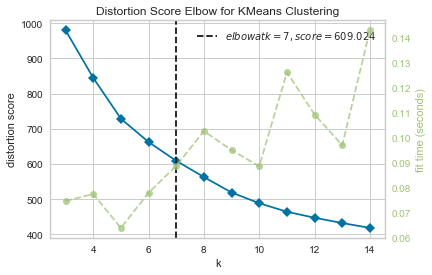

In [384]:
model = KMeans()
visualize = KElbowVisualizer(model, k=(3,15)) # Check for optimal clusters between 3-15

visualize.fit(mumbai_clustering)        # Fit the data 
visualize.show()  

### The above plot shows us the distortion score and fit time for each value of k.

### The ideal value of k is found to be 7. We proceed to fit our data with 7 clusters.

In [385]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(mumbai_clustering)

In [387]:
# Insert the cluster labels for each neighborhood into the final dataframe, final_df
final_df.insert(0, 'Cluster Labels', kmeans.labels_)
final_df.head()

,Cluster Labels,Neighborhood,Latitude,Longitude,Avg 2BHK Rent,Hospitals,Schools,Emergency Services,Leisure,Shopping Facilities,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,6,Thane West,19.175020,72.971802,27333.33,4,50,7,27,100,...,Smoke Shop,Indian Restaurant,Dessert Shop,Border Crossing,Fast Food Restaurant,Train Station,Dumpling Restaurant,Electronics Store,Event Space,Factory
1,6,Mira Road East,19.187896,72.836596,30000.00,30,45,4,23,100,...,Coffee Shop,Indian Restaurant,Fast Food Restaurant,Café,Pub,Chinese Restaurant,Clothing Store,Pizza Place,Italian Restaurant,Gym
2,3,Kharghar,19.025773,73.059185,32000.00,9,8,0,7,83,...,Café,Fast Food Restaurant,Multiplex,Train Station,Department Store,Indian Restaurant,Sandwich Place,Dhaba,Boutique,Falafel Restaurant
3,5,Chembur,19.061213,72.897591,39000.00,36,57,6,35,100,...,Indian Restaurant,Seafood Restaurant,Café,Ice Cream Shop,Pizza Place,Garden,Lounge,Fast Food Restaurant,Bar,Restaurant
4,3,Kandivali East,19.210381,72.864084,33694.62,30,18,3,19,100,...,Indian Restaurant,Fast Food Restaurant,Restaurant,Pizza Place,Shopping Mall,Lounge,Café,Multiplex,Ice Cream Shop,Chinese Restaurant


### We now visualize each cluster classification

In [491]:
# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set color scheme for each cluster
colors= ['#2E86C1', '#FCC3B6', '#FF007C', '#8CEF42', '#FBF427', '#5DADE2', '#D337D2']

# Add markers to the map
for lat, lon, poi, cluster in zip(final_df['Latitude'], final_df['Longitude'], final_df['Neighborhood'], final_df['Cluster Labels']):
    
    label = folium.Popup(str(poi) + ' ,Cluster ' + str(cluster), parse_html=True)
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.85).add_to(map_clusters)
# Display map
map_clusters

## We now begin to analayze each cluster.

### Cluster 1

In [492]:
# Print the neighborhood and their details, belonging to Cluster 1
cluster1 = final_df.loc[final_df['Cluster Labels'] == 0, final_df.columns[[1] + list(range(2, final_df.shape[1]))]]
cluster1

,Neighborhood,Latitude,Longitude,Avg 2BHK Rent,Hospitals,Schools,Emergency Services,Leisure,Shopping Facilities,Spiritual Centers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Powai,19.118720,72.907348,85000.00,1,22,3,33,100,27,Indian Restaurant,Ice Cream Shop,Café,Chinese Restaurant,Bar,Bakery,Coffee Shop,Restaurant,Lounge,Pub
45,Juhu,19.107021,72.827528,69000.00,11,45,5,36,100,20,Indian Restaurant,Café,Hotel,Bar,Coffee Shop,Chinese Restaurant,Cocktail Bar,Spa,Lounge,Restaurant
69,Colaba,18.915091,72.825969,128218.18,2,23,8,28,100,40,Indian Restaurant,Coffee Shop,Hotel,Café,Diner,Bar,Restaurant,Italian Restaurant,Chinese Restaurant,Tennis Court
86,Cuffe Parade,18.913641,72.820930,143326.09,1,19,6,23,100,30,Indian Restaurant,Coffee Shop,Chinese Restaurant,Restaurant,Spa,Italian Restaurant,Gym,Thai Restaurant,Pizza Place,Café
110,Malabar Hill,18.958162,72.803366,154210.53,18,46,10,31,100,56,Indian Restaurant,Café,Dessert Shop,Coffee Shop,Restaurant,Bakery,Park,Salon / Barbershop,Pizza Place,History Museum
111,Lokhandwala complex,19.143160,72.824633,63500.06,22,18,6,28,100,24,Indian Restaurant,Chinese Restaurant,Pub,Café,Bar,Italian Restaurant,Bakery,Gym / Fitness Center,Coffee Shop,Lounge
117,Versova,19.130252,72.821377,64300.00,30,34,3,36,100,42,Café,Pub,Indian Restaurant,Bar,Lounge,Ice Cream Shop,Pizza Place,Chinese Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant
131,Pali Hill,19.064913,72.827033,79000.00,12,34,2,46,100,46,Café,Indian Restaurant,Dessert Shop,Italian Restaurant,Bakery,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Ice Cream Shop,Asian Restaurant
143,Carter Road,19.060734,72.822291,131000.00,13,20,3,29,100,13,Café,Indian Restaurant,Bakery,Bar,Chinese Restaurant,Fast Food Restaurant,Asian Restaurant,Dessert Shop,Seafood Restaurant,Spa
156,Breach Candy,18.972566,72.804268,168000.00,12,21,7,27,100,34,Bar,Indian Restaurant,Bakery,Café,Dessert Shop,Pizza Place,Sandwich Place,Chinese Restaurant,Department Store,Italian Restaurant


In [493]:
# Create Map for Cluster 1 neighborhoods

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to the map
markers_colors = []
for lat, lon, poi in zip(cluster1['Latitude'], cluster1['Longitude'], cluster1['Neighborhood']):
    
    label = folium.Popup(str(poi) + ' ,Cluster 1', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[0],
        fill_opacity=0.85).add_to(map_clusters)
    
# Display map
map_clusters

### We now plot the frequency of the top 3 venues in each of the most common venue columns of all the neighborhoods belonging to Cluster 1. This will be especially useful to anyone looking to find preferences of people in Cluster 1 neighborhoods such as investors or realtors. 

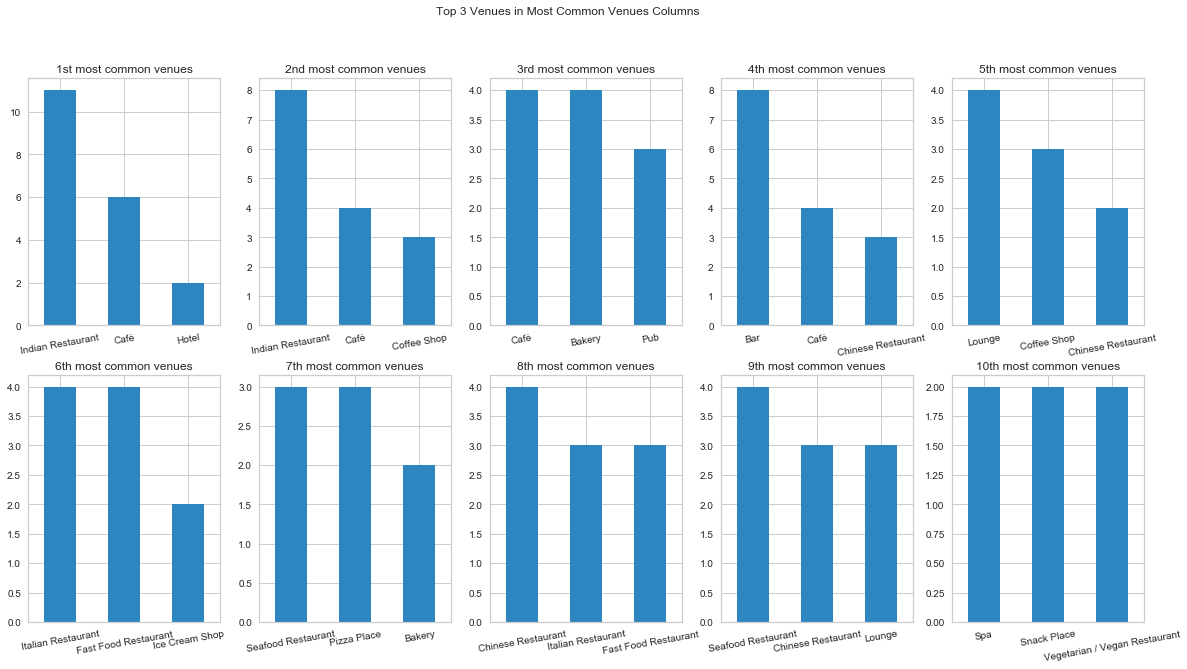

In [596]:
# Plot the bar graph for frequency of common venues in Cluster 1

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10)) # Specifying size and number of plots
x=0
y=0
fig.suptitle('Top 3 Venues in Most Common Venues Columns')

for i in range(10,20):
    
    try:
        cluster1.iloc[:,i].value_counts()[:3].plot('bar',ax=axes[x,y], color=colors[0]).set_title('{}{} most common venues'.format((i-9),indicators[i-10]))
        plt.setp(axes[x][y].xaxis.get_majorticklabels(), rotation=10)
    except:
        cluster1.iloc[:,i].value_counts()[:3].plot('bar',ax=axes[x,y], color=colors[0]).set_title('{}{} most common venues'.format((i-9),'th'))            
        plt.setp(axes[x][y].xaxis.get_majorticklabels(), rotation=10)
    if (y!=4):
        y=y+1
    else:
        x=x+1
        y=0

### Cluster 2

In [495]:
# Print the neighborhood and their details, belonging to Cluster 2
cluster2 = final_df.loc[final_df['Cluster Labels'] == 1, final_df.columns[[1] + list(range(2, final_df.shape[1]))]]
cluster2

,Neighborhood,Latitude,Longitude,Avg 2BHK Rent,Hospitals,Schools,Emergency Services,Leisure,Shopping Facilities,Spiritual Centers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Mulund West,19.171972,72.951196,26000.00,60,91,19,27,100,100,Indian Restaurant,Fast Food Restaurant,Snack Place,Café,Ice Cream Shop,Pizza Place,Asian Restaurant,Flea Market,Shopping Mall,Lounge
25,Naigaon East,19.009539,72.847871,8527.78,43,58,18,21,100,100,Indian Restaurant,Coffee Shop,Bus Station,Vegetarian / Vegan Restaurant,Movie Theater,Flower Shop,Café,Juice Bar,Lounge,Restaurant
36,mumbai,18.938771,72.835335,35428.08,30,43,30,27,100,76,Indian Restaurant,Café,Coffee Shop,Hotel,Seafood Restaurant,Fast Food Restaurant,Train Station,Bar,Bakery,Clothing Store
43,Mulund East,19.170472,72.961045,22000.00,24,71,16,30,100,81,Indian Restaurant,Café,Ice Cream Shop,Fast Food Restaurant,Chinese Restaurant,Pizza Place,Smoke Shop,Playground,Diner,Bus Station
80,Byculla,18.976622,72.832794,63250.00,24,84,29,30,100,100,Bakery,Indian Restaurant,Pizza Place,Coffee Shop,Zoo,Fast Food Restaurant,Restaurant,Bar,Asian Restaurant,Cupcake Shop
84,Mulund,19.172290,72.956469,3546.15,45,93,16,28,100,100,Indian Restaurant,Fast Food Restaurant,Café,Snack Place,Pizza Place,Ice Cream Shop,Chinese Restaurant,Flea Market,Theater,Bar
104,Suburbs Mumbai,18.958485,72.812252,43892.86,56,99,18,45,100,100,Indian Restaurant,Ice Cream Shop,Coffee Shop,Café,Fast Food Restaurant,Juice Bar,Pizza Place,Restaurant,Electronics Store,Clothing Store
107,Agripada,18.975302,72.824898,76500.00,6,85,22,20,100,100,Indian Restaurant,Fast Food Restaurant,Bakery,Gym,Restaurant,Chinese Restaurant,Department Store,Coffee Shop,Asian Restaurant,Movie Theater
112,Mumbai Central,18.969586,72.819315,6232.26,9,100,15,25,100,100,Fast Food Restaurant,Chinese Restaurant,Indian Restaurant,Coffee Shop,Restaurant,Department Store,Ice Cream Shop,Bakery,Golf Course,Athletics & Sports
148,Girgaon,18.954317,72.817908,121250.00,68,100,20,36,100,100,Indian Restaurant,Fast Food Restaurant,Juice Bar,Ice Cream Shop,Restaurant,Breakfast Spot,Bakery,Coffee Shop,Italian Restaurant,Gastropub


In [496]:
# Create Map for Cluster 2 neighborhoods
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to the map
for lat, lon, poi in zip(cluster2['Latitude'], cluster2['Longitude'], cluster2['Neighborhood']):
    
    label = folium.Popup(str(poi) + ' ,Cluster 2', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[1],
        fill_opacity=0.85).add_to(map_clusters)

# Display map
map_clusters

### We now plot the frequency of the top 3 venues in each of the most common venue columns of all the neighborhoods belonging to Cluster 2. This will be especially useful to anyone looking to find preferences of people in Cluster 2 neighborhoods such as investors or realtors. 

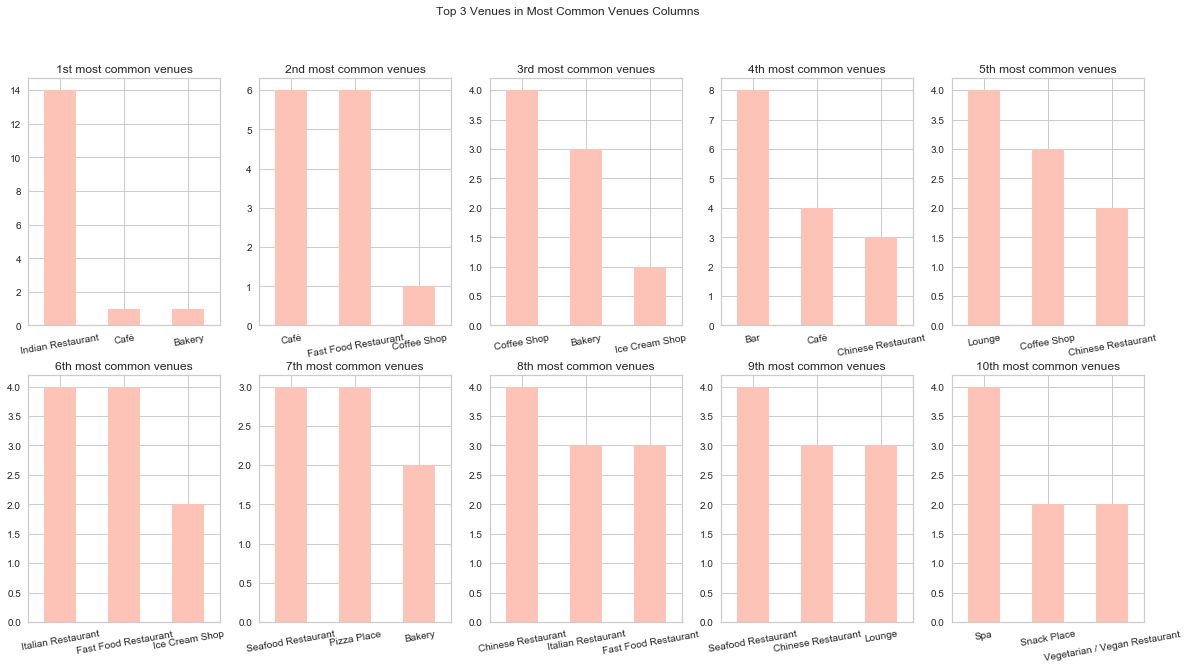

In [497]:
# Plot the bar graph for frequency of common venues in Cluster 2
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
x=0
y=0
fig.suptitle('Top 3 Venues in Most Common Venues Columns')
for i in range(10,20):
    try:
        cluster2.iloc[:,i].value_counts()[:3].plot('bar',ax=axes[x,y], color=colors[1]).set_title('{}{} most common venues'.format((i-9),indicators[i-10]))
        plt.setp(axes[x][y].xaxis.get_majorticklabels(), rotation=10)
    except:
        cluster1.iloc[:,i].value_counts()[:3].plot('bar',ax=axes[x,y], color=colors[1]).set_title('{}{} most common venues'.format((i-9),'th'))            
        plt.setp(axes[x][y].xaxis.get_majorticklabels(), rotation=10)
    if (y!=4):
        y=y+1
    else:
        x=x+1
        y=0

### Cluster 3

In [498]:
# Print the neighborhood and their details, belonging to Cluster 3
cluster3 = final_df.loc[final_df['Cluster Labels'] == 2, final_df.columns[[1] + list(range(2, final_df.shape[1]))]]
cluster3

,Neighborhood,Latitude,Longitude,Avg 2BHK Rent,Hospitals,Schools,Emergency Services,Leisure,Shopping Facilities,Spiritual Centers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Lower Parel,18.996332,72.830860,81000.00,11,31,11,37,100,87,Indian Restaurant,Café,Restaurant,Coffee Shop,Pub,Italian Restaurant,Lounge,Asian Restaurant,Mediterranean Restaurant,Clothing Store
33,Worli,19.011696,72.818070,57000.00,6,41,12,19,100,54,Scenic Lookout,Café,Bakery,Smoke Shop,Sports Club,Electronics Store,Thai Restaurant,French Restaurant,Chinese Restaurant,Art Gallery
38,Prabhadevi,19.014881,72.827956,93145.52,17,58,9,29,100,100,Indian Restaurant,Café,Coffee Shop,Chinese Restaurant,Electronics Store,Lounge,Snack Place,Restaurant,Bakery,Dessert Shop
40,Bandra East,19.061657,72.849811,75000.00,9,26,13,12,100,76,Indian Restaurant,Restaurant,Café,Gym,Pizza Place,Pub,Seafood Restaurant,Brazilian Restaurant,South American Restaurant,Food Court
41,Khar West,19.069658,72.839894,86500.00,20,16,13,25,100,81,Bar,Seafood Restaurant,Ice Cream Shop,Café,Sushi Restaurant,Dessert Shop,Asian Restaurant,Chinese Restaurant,Spa,Hookah Bar
44,Vikhroli,19.111480,72.928021,63708.00,13,34,9,22,100,49,Vegetarian / Vegan Restaurant,Café,Chinese Restaurant,Dessert Shop,Indian Restaurant,Coworking Space,Restaurant,Seafood Restaurant,Farm,Falafel Restaurant
67,Khar,19.069658,72.839894,65000.00,20,16,13,25,100,81,Bar,Seafood Restaurant,Ice Cream Shop,Café,Sushi Restaurant,Dessert Shop,Asian Restaurant,Chinese Restaurant,Spa,Hookah Bar
75,Mahalaxmi,18.982568,72.824160,55000.00,7,33,12,10,100,100,Coffee Shop,Indian Restaurant,Bakery,Gym,Restaurant,Asian Restaurant,Modern European Restaurant,Café,Spa,Racetrack
76,Dadar East,19.016253,72.852227,81333.38,11,62,9,25,100,85,Indian Restaurant,Coffee Shop,Fast Food Restaurant,Café,Movie Theater,Gym,Shoe Store,Soccer Field,Flower Shop,Restaurant
92,MATUNGA WEST,19.031726,72.843392,64846.15,14,56,13,28,100,88,Indian Restaurant,Chinese Restaurant,Fast Food Restaurant,Café,Bar,Vegetarian / Vegan Restaurant,Coffee Shop,Pizza Place,Department Store,Movie Theater


In [499]:
# Create Map for Cluster 2 neighborhoods
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to the map
for lat, lon, poi in zip(cluster3['Latitude'], cluster3['Longitude'], cluster3['Neighborhood']):
    
    label = folium.Popup(str(poi) + ' ,Cluster 3', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[2],
        fill_opacity=0.85).add_to(map_clusters)
# Display map
map_clusters

### We now plot the frequency of the top 3 venues in each of the most common venue columns of all the neighborhoods belonging to Cluster 3. This will be especially useful to anyone looking to find preferences of people in Cluster 3 neighborhoods such as investors or realtors. 

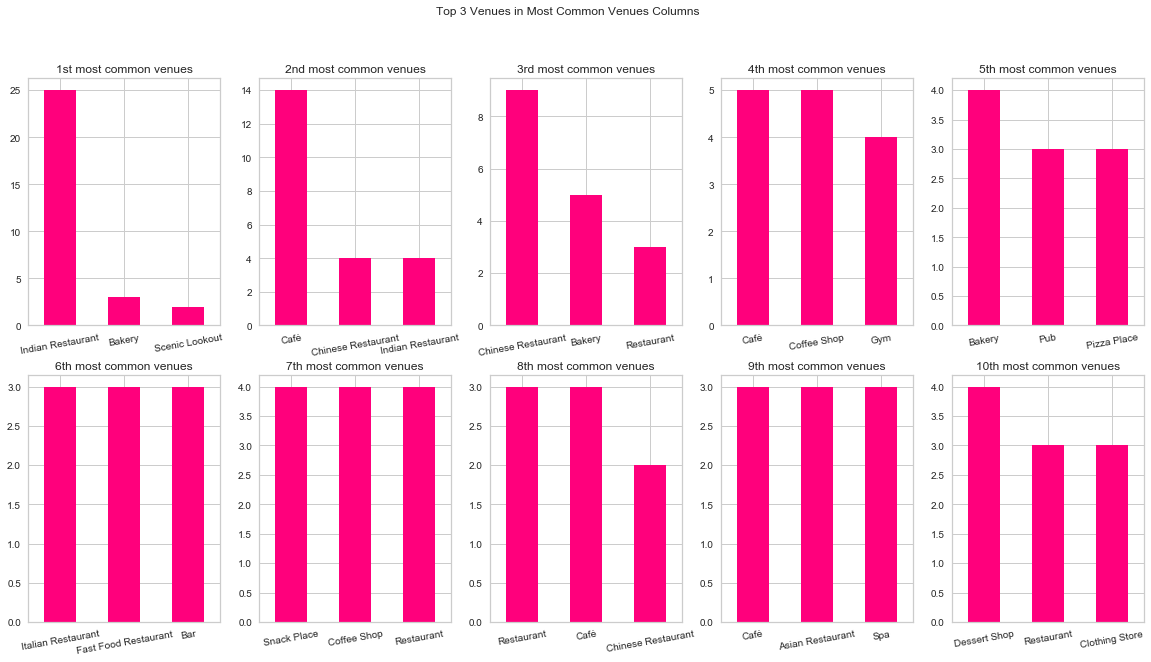

In [500]:
# Plot the bar graph for frequency of common venues in Cluster 3
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
x=0
y=0
fig.suptitle('Top 3 Venues in Most Common Venues Columns')
for i in range(10,20):
    try:
        cluster3.iloc[:,i].value_counts()[:3].plot('bar',ax=axes[x,y], color=colors[2]).set_title('{}{} most common venues'.format((i-9),indicators[i-10]))
        plt.setp(axes[x][y].xaxis.get_majorticklabels(), rotation=10)
    except:
        cluster3.iloc[:,i].value_counts()[:3].plot('bar',ax=axes[x,y], color=colors[2]).set_title('{}{} most common venues'.format((i-9),'th'))            
        plt.setp(axes[x][y].xaxis.get_majorticklabels(), rotation=10)
    if (y!=4):
        y=y+1
    else:
        x=x+1
        y=0

### Cluster 4

In [501]:
# Print the neighborhood and their details, belonging to Cluster 4
cluster4 = final_df.loc[final_df['Cluster Labels'] == 3, final_df.columns[[1] + list(range(2, final_df.shape[1]))]]
cluster4

,Neighborhood,Latitude,Longitude,Avg 2BHK Rent,Hospitals,Schools,Emergency Services,Leisure,Shopping Facilities,Spiritual Centers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Kharghar,19.025773,73.059185,32000.00,9,8,0,7,83,10,Café,Fast Food Restaurant,Multiplex,Train Station,Department Store,Indian Restaurant,Sandwich Place,Dhaba,Boutique,Falafel Restaurant
4,Kandivali East,19.210381,72.864084,33694.62,30,18,3,19,100,31,Indian Restaurant,Fast Food Restaurant,Restaurant,Pizza Place,Shopping Mall,Lounge,Café,Multiplex,Ice Cream Shop,Chinese Restaurant
10,Panvel,19.050027,72.933334,12284.81,8,41,5,1,94,50,ATM,Coffee Shop,Train Station,Sports Bar,Factory,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space
14,Kalyan West,19.137892,72.810668,18000.00,2,7,2,20,53,38,Café,Beach,Restaurant,Coffee Shop,Diner,Chinese Restaurant,Sandwich Place,Middle Eastern Restaurant,Miscellaneous Shop,Boat or Ferry
26,Santacruz East,19.092337,72.853199,50000.00,7,22,6,8,85,33,Café,Indian Restaurant,Coffee Shop,Hotel,Sandwich Place,Bar,Restaurant,Donut Shop,Bakery,Fast Food Restaurant
29,Kanjurmarg,19.129687,72.928370,43620.57,6,37,14,11,100,47,Train Station,Fish Market,Platform,Café,Asian Restaurant,Cupcake Shop,Indian Restaurant,Food Court,Multiplex,Coffee Shop
30,Wadala,19.026919,72.875934,58982.25,0,18,4,15,82,36,Snack Place,Gym Pool,Bookstore,Baseball Field,Coffee Shop,Pizza Place,Thai Restaurant,Asian Restaurant,Multiplex,Electronics Store
31,Ghansoli,19.119331,72.999510,5500.00,11,31,1,5,100,24,Flea Market,Fast Food Restaurant,Department Store,Vegetarian / Vegan Restaurant,Train Station,Juice Bar,Zoo,Electronics Store,Diner,Donut Shop
32,Neral,19.026637,73.318118,26250.00,4,27,2,1,100,35,ATM,Train Station,City,Mountain,Fast Food Restaurant,Farmers Market,Farm,Field,Dim Sum Restaurant,Fish & Chips Shop
39,Seawoods,19.022192,73.018738,28000.00,19,15,3,23,100,16,Dessert Shop,Fast Food Restaurant,Indian Restaurant,Garden,Chinese Restaurant,Café,Shopping Mall,Department Store,Music Store,Clothing Store


In [502]:
# Create Map for Cluster 4 neighborhoods
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to the map
for lat, lon, poi in zip(cluster4['Latitude'], cluster4['Longitude'], cluster4['Neighborhood']):
    
    label = folium.Popup(str(poi) + ' ,Cluster 4', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[3],
        fill_opacity=0.85).add_to(map_clusters)
    
# Display map
map_clusters

### We now plot the frequency of the top 3 venues in each of the most common venue columns of all the neighborhoods belonging to Cluster 4. This will be especially useful to anyone looking to find preferences of people in Cluster 4 neighborhoods such as investors or realtors. 

In [ ]:
# Plot the bar graph for frequency of common venues in Cluster 4
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
x=0
y=0
fig.suptitle('Top 3 Venues in Most Common Venues Columns')
for i in range(10,20):
    try:
        cluster4.iloc[:,i].value_counts()[:3].plot('bar',ax=axes[x,y], color=colors[3]).set_title('{}{} most common venues'.format((i-9),indicators[i-10]))
        plt.setp(axes[x][y].xaxis.get_majorticklabels(), rotation=10)
    except:
        cluster4.iloc[:,i].value_counts()[:3].plot('bar',ax=axes[x,y], color=colors[3]).set_title('{}{} most common venues'.format((i-9),'th'))            
        plt.setp(axes[x][y].xaxis.get_majorticklabels(), rotation=10)
    if (y!=4):
        y=y+1
    else:
        x=x+1
        y=0

### Cluster 5

In [504]:
# Print the neighborhood and their details, belonging to Cluster 5
cluster5 = final_df.loc[final_df['Cluster Labels'] == 4, final_df.columns[[1] + list(range(2, final_df.shape[1]))]]
cluster5

,Neighborhood,Latitude,Longitude,Avg 2BHK Rent,Hospitals,Schools,Emergency Services,Leisure,Shopping Facilities,Spiritual Centers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Ulwe,18.980436,73.038731,10000.00,0,1,0,0,1,2,Pizza Place,Department Store,Italian Restaurant,Dhaba,Zoo,Event Space,Diner,Donut Shop,Dumpling Restaurant,Electronics Store
9,Virar,19.467682,72.887997,8000.00,0,2,1,0,2,6,Resort,Restaurant,Bus Station,Indian Restaurant,Electronics Store,Diner,Donut Shop,Dumpling Restaurant,Zoo,Dim Sum Restaurant
19,Kamothe,19.016434,73.080655,15722.09,10,10,0,0,19,2,Asian Restaurant,Multiplex,Train Station,Cupcake Shop,Factory,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space,Falafel Restaurant
23,Airoli,19.151749,72.974477,28269.23,0,0,0,0,4,0,Punjabi Restaurant,Zoo,Dhaba,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Factory
28,Taloja,19.061486,73.116139,11606.06,2,0,3,0,4,1,Business Service,Comedy Club,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Factory
37,Virar West,19.467682,72.887997,20000.00,0,2,1,0,2,6,Resort,Restaurant,Bus Station,Indian Restaurant,Electronics Store,Diner,Donut Shop,Dumpling Restaurant,Zoo,Dim Sum Restaurant
56,Kalamboli,19.023506,73.110609,1647.17,9,7,7,2,34,13,Bus Station,Hotel,Fast Food Restaurant,Department Store,Toll Plaza,Event Space,Diner,Donut Shop,Dumpling Restaurant,Electronics Store
62,Virar East,19.467682,72.887997,8000.00,0,2,1,0,2,6,Resort,Restaurant,Bus Station,Indian Restaurant,Electronics Store,Diner,Donut Shop,Dumpling Restaurant,Zoo,Dim Sum Restaurant
64,Bhayandar East,19.197152,72.811366,15000.00,1,11,2,6,11,26,Resort,Hot Dog Joint,Diner,Dance Studio,Event Space,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Zoo
71,Bandra Kurla Complex,19.067115,72.865724,10253.35,6,8,5,6,24,13,Indian Restaurant,Bar,Coffee Shop,Pizza Place,Sandwich Place,Fast Food Restaurant,Chinese Restaurant,Dessert Shop,Diner,Café


In [505]:
# Create Map for Cluster 5 neighborhoods
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to the map
markers_colors = []
for lat, lon, poi in zip(cluster5['Latitude'], cluster5['Longitude'], cluster5['Neighborhood']):
    
    label = folium.Popup(str(poi) + ' ,Cluster 5', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[4],
        fill_opacity=0.85).add_to(map_clusters)
    
# Display map
map_clusters

### We now plot the frequency of the top 3 venues in each of the most common venue columns of all the neighborhoods belonging to Cluster 5. This will be especially useful to anyone looking to find preferences of people in Cluster 5 neighborhoods such as investors or realtors. 

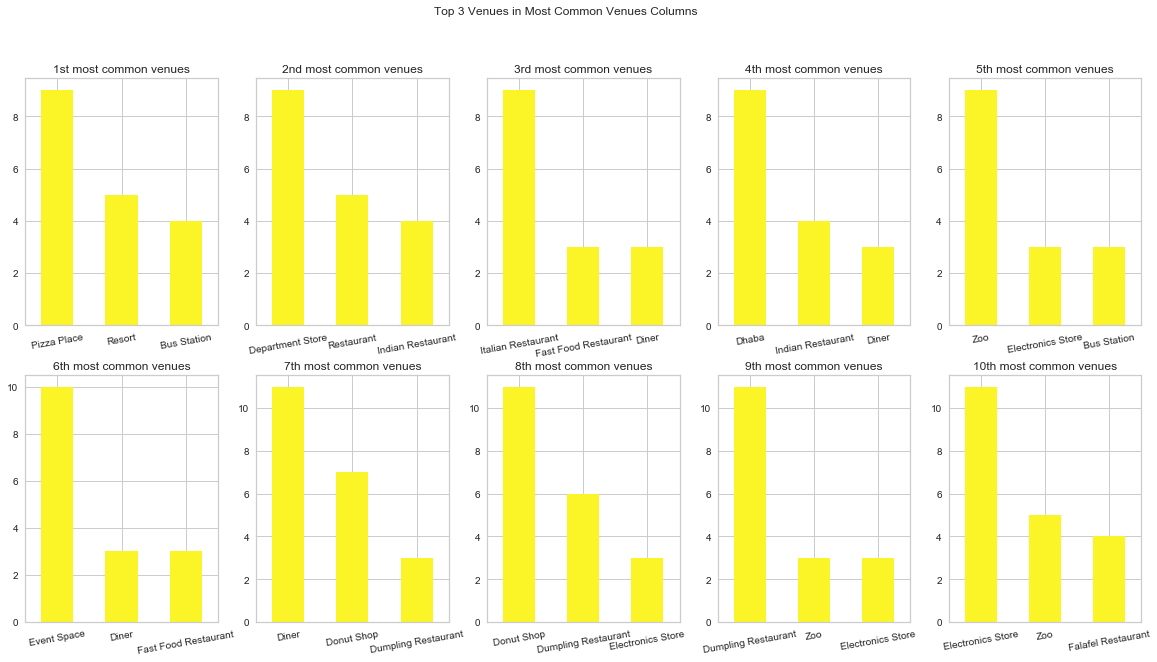

In [506]:
# Plot the bar graph for frequency of common venues in Cluster 5
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
x=0
y=0
fig.suptitle('Top 3 Venues in Most Common Venues Columns')
for i in range(10,20):
    try:
        cluster5.iloc[:,i].value_counts()[:3].plot('bar',ax=axes[x,y], color=colors[4]).set_title('{}{} most common venues'.format((i-9),indicators[i-10]))
        plt.setp(axes[x][y].xaxis.get_majorticklabels(), rotation=10)
    except:
        cluster5.iloc[:,i].value_counts()[:3].plot('bar',ax=axes[x,y], color=colors[4]).set_title('{}{} most common venues'.format((i-9),'th'))            
        plt.setp(axes[x][y].xaxis.get_majorticklabels(), rotation=10)
    if (y!=4):
        y=y+1
    else:
        x=x+1
        y=0

### Cluster 6

In [507]:
# Print the neighborhood and their details, belonging to Cluster 6
cluster6 = final_df.loc[final_df['Cluster Labels'] == 5, final_df.columns[[1] + list(range(2, final_df.shape[1]))]]
cluster6

,Neighborhood,Latitude,Longitude,Avg 2BHK Rent,Hospitals,Schools,Emergency Services,Leisure,Shopping Facilities,Spiritual Centers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Chembur,19.061213,72.897591,39000.00,36,57,6,35,100,98,Indian Restaurant,Seafood Restaurant,Café,Ice Cream Shop,Pizza Place,Garden,Lounge,Fast Food Restaurant,Bar,Restaurant
13,Malad West,19.184013,72.841216,31750.00,53,28,6,23,100,97,Fast Food Restaurant,Coffee Shop,Indian Restaurant,Café,Chinese Restaurant,Pizza Place,Bar,Clothing Store,Italian Restaurant,Pub
15,Borivali West,19.229456,72.847990,316.80,30,70,8,43,100,77,Indian Restaurant,Restaurant,Ice Cream Shop,Sandwich Place,Chinese Restaurant,Gym,Theater,Café,Fast Food Restaurant,Clothing Store
16,Bandra West,19.058336,72.830267,44500.00,44,50,12,50,100,67,Café,Indian Restaurant,Bakery,Bar,Dessert Shop,Seafood Restaurant,Chinese Restaurant,Pizza Place,Asian Restaurant,Snack Place
17,Dahisar,19.249450,72.859621,21502.46,62,64,12,21,100,100,Diner,Bar,Juice Bar,Chinese Restaurant,Indian Restaurant,Café,Ice Cream Shop,Dessert Shop,Department Store,Restaurant
18,Bhandup West,19.146264,72.933946,31000.00,56,89,7,15,100,81,Indian Restaurant,Train Station,Arcade,Sports Bar,Fried Chicken Joint,Big Box Store,Falafel Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Café
35,Parel,19.009482,72.837661,65000.00,81,81,16,26,100,100,Indian Restaurant,Coffee Shop,Restaurant,Movie Theater,Bakery,Theater,Burger Joint,Juice Bar,Café,Department Store
47,Nerul,19.033612,73.018140,25000.00,40,71,3,52,100,72,Indian Restaurant,Chinese Restaurant,Café,Gym,Snack Place,Coffee Shop,Bakery,Diner,Food Court,Garden
49,Ghatkopar West,19.089719,72.904597,30750.00,91,99,7,18,100,100,Indian Restaurant,Pizza Place,Café,Men's Store,Smoke Shop,Restaurant,Light Rail Station,Donut Shop,Bakery,Dessert Shop
54,Vashi,19.075713,73.000354,30187.50,58,30,7,35,100,52,Indian Restaurant,Fast Food Restaurant,Gym / Fitness Center,Hotel,Chaat Place,Beer Garden,Social Club,Snack Place,Shopping Mall,Seafood Restaurant


In [508]:
# Create Map for Cluster 6 neighborhoods
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to the map
for lat, lon, poi in zip(cluster6['Latitude'], cluster6['Longitude'], cluster6['Neighborhood']):
    
    label = folium.Popup(str(poi) + ' ,Cluster 6', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[5],
        fill_opacity=0.85).add_to(map_clusters)

# Display map
map_clusters

### We now plot the frequency of the top 3 venues in each of the most common venue columns of all the neighborhoods belonging to Cluster 6. This will be especially useful to anyone looking to find preferences of people in Cluster 6 neighborhoods such as investors or realtors. 

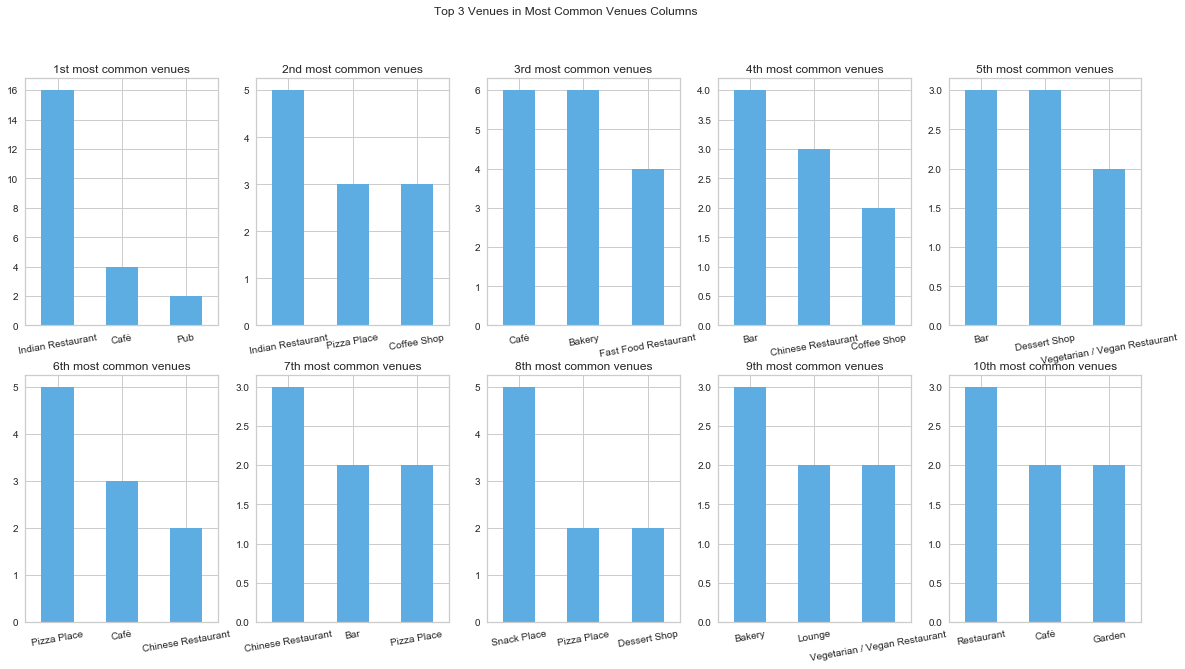

In [509]:
# Plot the bar graph for frequency of common venues in Cluster 6
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
x=0
y=0
fig.suptitle('Top 3 Venues in Most Common Venues Columns')
for i in range(10,20):
    try:
        cluster6.iloc[:,i].value_counts()[:3].plot('bar',ax=axes[x,y], color=colors[5]).set_title('{}{} most common venues'.format((i-9),indicators[i-10]))
        plt.setp(axes[x][y].xaxis.get_majorticklabels(), rotation=10)
    except:
        cluster6.iloc[:,i].value_counts()[:3].plot('bar',ax=axes[x,y], color=colors[5]).set_title('{}{} most common venues'.format((i-9),'th'))            
        plt.setp(axes[x][y].xaxis.get_majorticklabels(), rotation=10)
    if (y!=4):
        y=y+1
    else:
        x=x+1
        y=0

### Cluster 7

In [510]:
# Print the neighborhood and their details, belonging to Cluster 7
cluster7 = final_df.loc[final_df['Cluster Labels'] == 6, final_df.columns[[1] + list(range(2, final_df.shape[1]))]]
cluster7

,Neighborhood,Latitude,Longitude,Avg 2BHK Rent,Hospitals,Schools,Emergency Services,Leisure,Shopping Facilities,Spiritual Centers,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Thane West,19.175020,72.971802,27333.33,4,50,7,27,100,54,Smoke Shop,Indian Restaurant,Dessert Shop,Border Crossing,Fast Food Restaurant,Train Station,Dumpling Restaurant,Electronics Store,Event Space,Factory
1,Mira Road East,19.187896,72.836596,30000.00,30,45,4,23,100,63,Coffee Shop,Indian Restaurant,Fast Food Restaurant,Café,Pub,Chinese Restaurant,Clothing Store,Pizza Place,Italian Restaurant,Gym
6,Goregaon East,19.169262,72.855255,30000.00,9,49,6,25,100,58,Fast Food Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Hotel,Multiplex,Donut Shop,Snack Place,Shopping Mall,Bookstore,Bar
8,Andheri East,19.115883,72.854202,22000.00,20,53,9,18,100,78,Indian Restaurant,Fast Food Restaurant,Café,Gym,Restaurant,Food Court,Hotel,Chinese Restaurant,Shopping Mall,Asian Restaurant
11,Andheri West,19.117249,72.833968,56333.33,36,35,8,21,100,50,Indian Restaurant,Coffee Shop,Multiplex,Gym,Vegetarian / Vegan Restaurant,Café,Pub,Clothing Store,Ice Cream Shop,Snack Place
20,Borivali East,19.226723,72.861933,33815.34,29,44,10,26,100,81,Clothing Store,Ice Cream Shop,Department Store,Café,Indian Restaurant,Chinese Restaurant,Shopping Mall,Snack Place,Boat or Ferry,Pizza Place
21,Kandivali West,19.208380,72.842227,55000.00,23,74,7,29,100,69,Fast Food Restaurant,Pizza Place,Indian Restaurant,Coffee Shop,Food,Bike Rental / Bike Share,Restaurant,Food Truck,Dessert Shop,Men's Store
22,Malad East,19.186022,72.856318,46523.89,33,74,5,16,100,94,Department Store,Snack Place,Dessert Shop,Metro Station,Gym / Fitness Center,Pizza Place,Ice Cream Shop,Indian Restaurant,Factory,Dumpling Restaurant
24,Goregaon West,19.163328,72.841200,43000.00,30,41,4,30,100,84,Indian Restaurant,Fast Food Restaurant,Multiplex,Gym / Fitness Center,Ice Cream Shop,Mobile Phone Shop,Soccer Field,Sandwich Place,Restaurant,Café
34,Jogeshwari West,19.136394,72.837382,35666.67,30,30,4,26,100,65,Indian Restaurant,Pub,Bar,Asian Restaurant,Coffee Shop,Chinese Restaurant,Multiplex,Brewery,Pizza Place,Electronics Store


In [511]:
# Create Map for Cluster 7 neighborhoods
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers to the map
for lat, lon, poi in zip(cluster7['Latitude'], cluster7['Longitude'], cluster7['Neighborhood']):
    
    label = folium.Popup(str(poi) + ' ,Cluster 7', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[6],
        fill_opacity=0.85).add_to(map_clusters)

# Display map
map_clusters

### We now plot the frequency of the top 3 venues in each of the most common venue columns of all the neighborhoods belonging to Cluster 7. This will be especially useful to anyone looking to find preferences of people in Cluster 7 neighborhoods such as investors or realtors. 

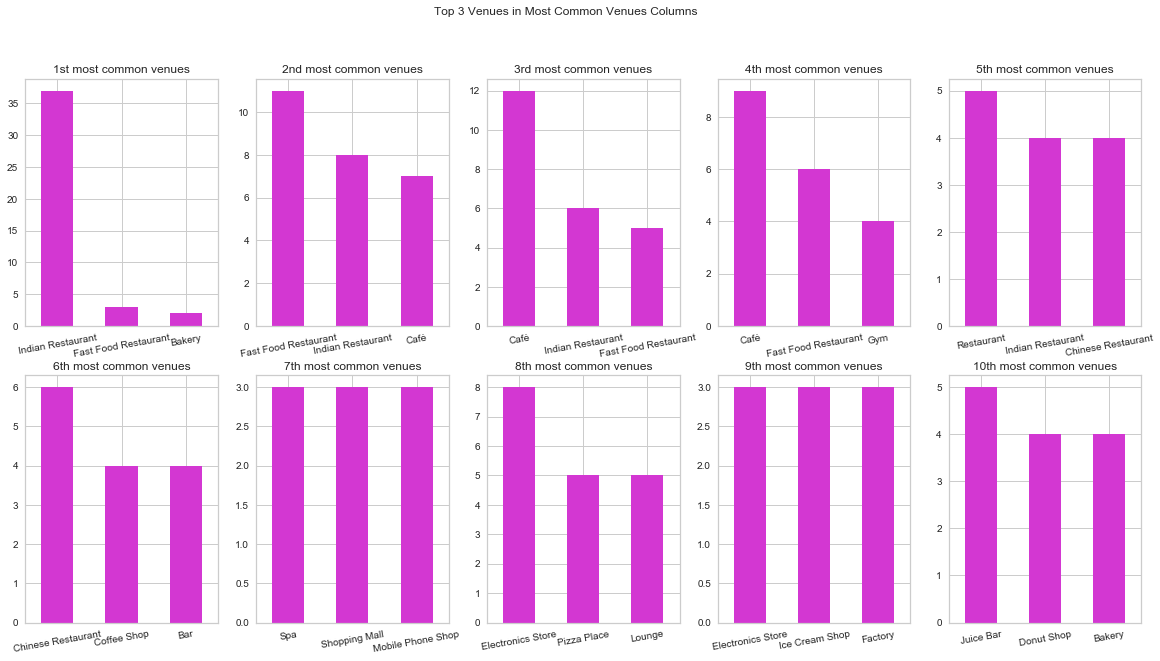

In [512]:
# Plot the bar graph for frequency of common venues in Cluster 7
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
x=0
y=0
fig.suptitle('Top 3 Venues in Most Common Venues Columns')
for i in range(10,20):
    try:
        cluster7.iloc[:,i].value_counts()[:3].plot('bar',ax=axes[x,y], color=colors[6]).set_title('{}{} most common venues'.format((i-9),indicators[i-10]))
        plt.setp(axes[x][y].xaxis.get_majorticklabels(), rotation=10)
    except:
        cluster7.iloc[:,i].value_counts()[:3].plot('bar',ax=axes[x,y], color=colors[6]).set_title('{}{} most common venues'.format((i-9),'th'))            
        plt.setp(axes[x][y].xaxis.get_majorticklabels(), rotation=10)
    if (y!=4):
        y=y+1
    else:
        x=x+1
        y=0

## For our final comparison we have plot the average value of the prices and facilities of different clusters against each other.

In [592]:
# Function to find the average value of 'name' category and plot a bar graph comparison
def comparing_clusters(final_df, name):
    
    category = []
    
    # Find mean of 'name' category in each of the cluster
    for i in range(0,7):
        category.append((final_df.loc[final_df['Cluster Labels'] == i])[name].mean())
        
    # Plot the bar chart for category 'name'
    
    fig, axes = plt.subplots(figsize=(7,7))
    
    # Create 7 cluster bars each with a height equal to the mean value of the facility
    bars = axes.bar(
        x=np.arange(1,8),
        height=category,
        color='#98cf3a'
    )
    
    fig.suptitle('Mean {} for different clusters'.format(name), fontsize=15,weight='bold')
    plt.xlabel('Cluster Numbers', fontsize=15)
    plt.ylabel('{}'.format(name), fontsize=15)
    
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_color('black')
    axes.spines['bottom'].set_color('black')
    axes.set_axisbelow(True)
    axes.yaxis.grid(False)
    axes.xaxis.grid(False)
    
    # Write the precise value above each bar
    for bar in bars:
        axes.text(
          bar.get_x() + bar.get_width() / 2,
          bar.get_height() + 0.3,
          round(bar.get_height(), 2),
          horizontalalignment='center',
          color='black',
          weight='bold'
        )
    fig.tight_layout()

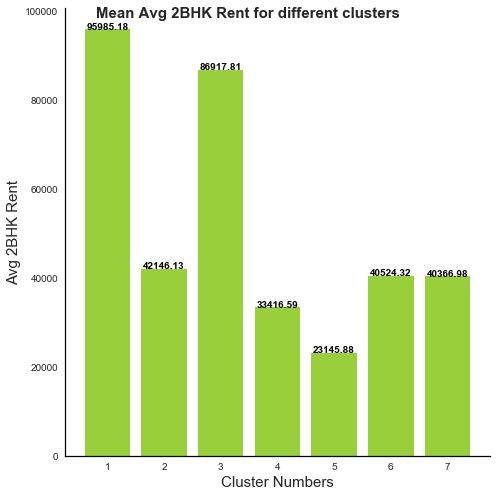

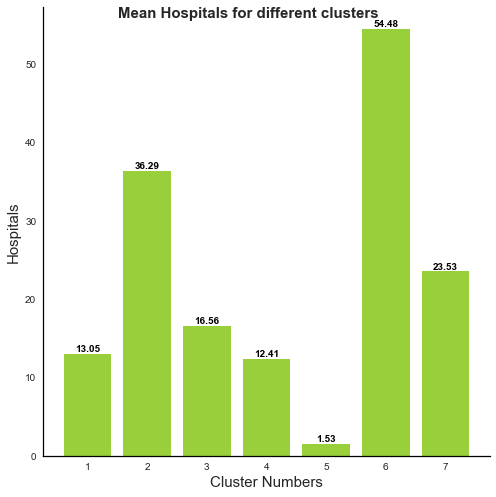

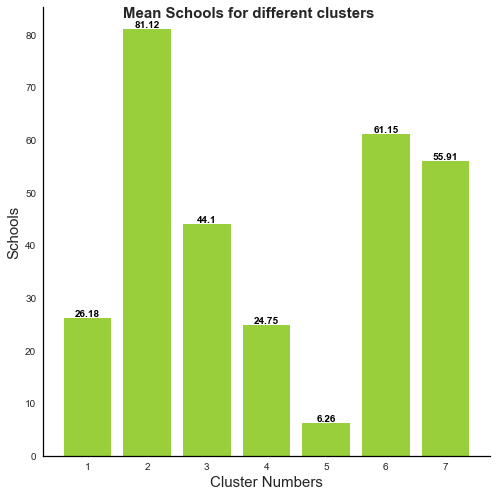

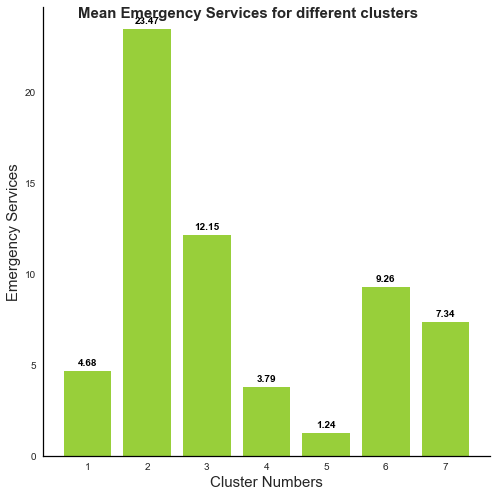

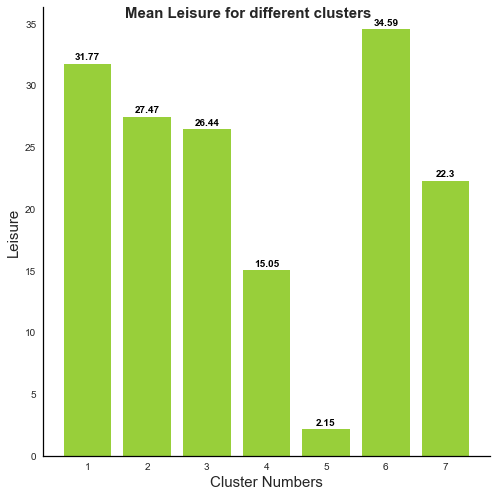

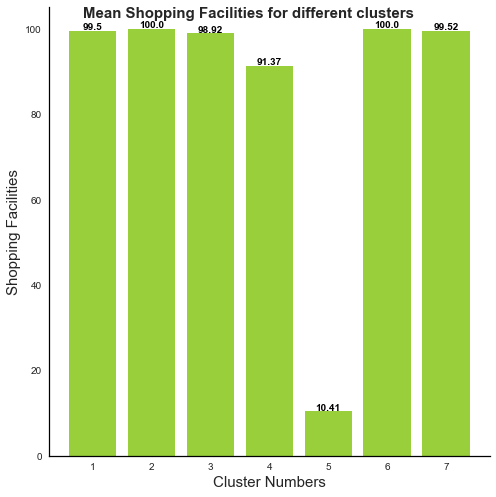

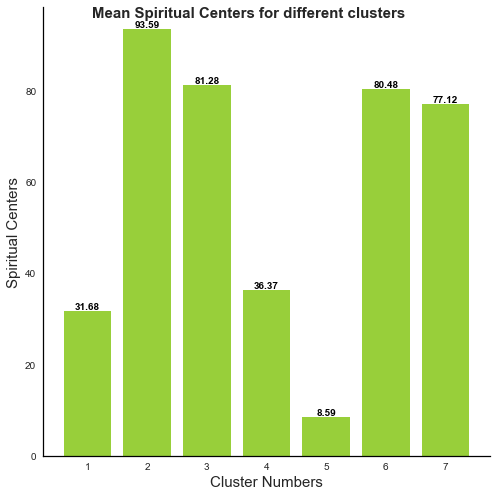

In [593]:
# Call the above function for all numerical values
for i in range(4,11):
    comparing_clusters(final_df, final_df.columns[i])